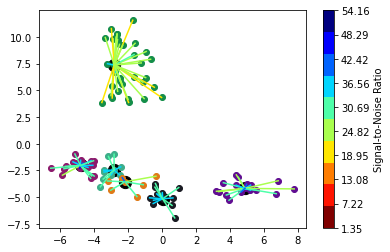

0.7642884254455566
{'Cluster Head': 'client21', 'Members': ['client6', 'client35', 'client43', 'client71', 'client93', 'client95'], 'SNR': [26.187133467238425, 30.22498302692484, 26.559150174150833, 24.511909641771222, 38.37803999569241, 30.64659883726337], 'CSI': [0.6228815374828597, 0.4062937159618538, 0.6604682244634547, 0.9936827048487684, 0.5035059759082021, 0.8999372051109396]}


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import syft as sy
import numpy as np
from Dataset import load_dataset, getImage
from utils import averageModels
from utils import averageModelscluster
import random
import math
import matplotlib.pyplot as plt
from ipynb.fs.full.K_clusters import cluster_former
from copy import deepcopy

In [2]:
P=2 #signal power threshold
#stream = BitStream()
#random.seed(10)
key=[]
for i in range (10000): #generating a random password to activate training (Pilot signal)
    temp=random.randint(0,1)
    key.append(temp)

key1=[0]*len(key)
for i in range (len(key)):   #bpsk modulation
    if(key[i]==1):
        #print("yay")
        key1[i]=-math.sqrt(P)
    else:
        key1[i]=math.sqrt(P)

#print(key)
        
key_np=np.array(key1)

In [3]:
class Arguments():
    def __init__(self):
        self.images = 10000
        self.clients = 50
        self.rounds = 200
        self.epochs = 2
        self.local_batches = 64
        self.lr = 0.001
        self.C = 1 #fraction of clients used in the round
        self.drop_rate = 0 #fraction of devices in the selected set to be dropped for various reasons
        self.torch_seed = 0 #same weights and parameters whenever the program is run
        self.log_interval = 64
        self.iid = 'iid'
        self.split_size = int(self.images / self.clients)
        self.samples = self.split_size / self.images 
        self.use_cuda = False
        self.save_model = True
        self.numclusters=3

args = Arguments()

In [4]:
#checking if gpu is available
#use_cuda = args.use_cuda and torch.cuda.is_available()
use_cuda=False
device = torch.device("cuda:0" if use_cuda else "cpu")
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

hook = sy.TorchHook(torch)
me = hook.local_worker
clients = []

#generating virtual clients
for i in range(args.clients):
    clients.append({'hook': sy.VirtualWorker(hook, id="client{}".format(i+1))})
#print(clients)

In [5]:
global_train, global_test, train_group, test_group = load_dataset(args.clients, args.iid) #load data

for inx, client in enumerate(clients):  #return actual image set for each client
    trainset_ind_list = list(train_group[inx]) 
    client['trainset'] = getImage(global_train, trainset_ind_list, args.local_batches)
    client['testset'] = getImage(global_test, list(test_group[inx]), args.local_batches)
    client['samples'] = len(trainset_ind_list) / args.images #useful while taking weighted average


In [6]:
#load dataset for global model (to compare accuracies)
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
global_test_dataset = datasets.MNIST('./', train=False, download=True, transform=transform)
# global_test_dataset = torch.utils.data.random_split(global_test_dataset, [10000, len(global_test_dataset)-10000])[0]
global_test_loader = DataLoader(global_test_dataset, batch_size=args.local_batches, shuffle=True)

In [7]:
"""class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #self.quant = torch.quantization.QuantStub()
        self.conv1 = nn.Conv2d(1, 5, 5, 1)
        self.conv2 = nn.Conv2d(5, 10, 5, 1)
        self.fc1 = nn.Linear(4*4*10, 50) #10 iid #50 non iid
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        #x=self.quant(x)
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*10
                   )
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1) """

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [8]:
def fedprox(params,global_params):
    global_param=[]
    ind=0
    for gp in global_params:
        global_param.append(gp)
    for p in params:
    #                 print(p.grad)
        lr=0.01
        mu=0.1
        if(p.grad is None):
            continue
        grad=p.grad.data #batch gradients
        p.data.sub_(lr,(grad+mu*(p.data.clone()-global_param[ind].data.clone())))
        ind+=1
    return(p)

In [9]:
def ClientUpdate(args, device, client,key_np,key,snr,csi,mu,head):
    gc=False
    client['model'].train()
    #simulating a wireless channel
    poptim=max((1/mu-1/csi),0)
    #print(mu,csi)
    print("Power Allocated=",poptim)
    print("CSI=",csi)
    
    snr__=10**(snr/10)
    
    absh=csi*poptim/snr__
    x=random.uniform(0,absh)
    #print(x)
    y=math.sqrt(absh*absh-x*x)
    #x=x*100
    #y=y*100
    #x=random.random()
    #y=random.random()
    #snr=10*math.log(poptim/(std*std),10)
    std=math.sqrt(poptim/snr__*absh*absh) #channel noise
    
    #print(x,y)
    h=complex(x,y)
    #std=math.sqrt(abs(h)/csi)
    #snr=poptim/(std*std)
    #print(std)
    print("SNR=",snr)
    #print("csi",abs(h)/(std*std))
    
    
    if(poptim!=0):
        data=client['model'].conv1.weight
        #data=data.cuda()
        data=data*math.sqrt(poptim) #transmitted signal
        #print(power)
        if(use_cuda):
            data=h*data+(torch.randn(data.size())*std).cuda() #channel affecting data
        else:
            data=h*data+(torch.randn(data.size())*std)
        data=data/(math.sqrt(poptim)*(h))  #demodulating received data
        data=data.real #demodulating received data
        client['model'].conv1.weight.data=data
        
        
        
        data=client['model'].conv2.weight
        #data=data.cuda()
        data=data*math.sqrt(poptim) #transmitted signal
        if(use_cuda):
            data=h*data+(torch.randn(data.size())*std).cuda() #channel affecting data
        else:
            data=h*data+(torch.randn(data.size())*std)
        data=data/(math.sqrt(poptim)*(h))  #demodulating received data
        data=data.real #demodulating received data
        client['model'].conv2.weight.data=data

    
    #print(client['model'].conv1.weight.size)
    client['model'].send(client['hook'])
    head['model'].send(client['hook'])
    print("Client:",client['hook'].id)
    
    key_np_received=h*key_np+(np.random.randn(len(key_np))*std*2)
    #print(key_np_received)
    key_np_received=(key_np_received/(h)).real
    
    for o in range (len(key_np_received)):  #demodulation bpsk
        if(key_np_received[o]>=0):
            key_np_received[o]=0
        else:
            key_np_received[o]=1
    
    key_np_received=key_np_received.tolist()
    key_np_received = [int(item) for item in key_np_received]
    #key_np=key_np.tolist()
    
    
    if(sum(np.bitwise_xor(key,key_np_received))/len(key)==0 and poptim>0): #...............................................checking if channel is good enough for transmission by checking BER..................................#
        gc=True #considering the client model for training
        for epoch in range(1, args.epochs + 1):
            for batch_idx, (data, target) in enumerate(client['trainset']): 
                data = data.send(client['hook'])
                target = target.send(client['hook'])
                #client['optim'].zero_grad()
                #train model on client
                data, target = data.to(device), target.to(device) #send data to cpu/gpu (data is stored locally)
                output = client['model'](data)
                loss = F.nll_loss(output, target)
                loss.backward()
                #client['optim'].step()
                params=client['model'].parameters()
                gp=head['model'].parameters()
                params=fedprox(params,gp) 
                
                if batch_idx % args.log_interval == 0:
                    loss = loss.get() 
                    print('Model {} Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                        client['hook'].id,
                        epoch, batch_idx * args.local_batches, len(client['trainset']) * args.local_batches, 
                        100. * batch_idx / len(client['trainset']), loss))
    else:
        print("Poor Channel, client not taken for averaging in this round")
            
                    
    client['model'].get()
    head['model'].get()
    # print()
         #CHANGE
    if(poptim!=0):
        data=client['model'].conv1.weight
        #data=data.cuda()
        data=data*math.sqrt(poptim) #transmitted signal
        #print(power)
        if(use_cuda):
            data=h*data+(torch.randn(data.size())*std).cuda() #channel affecting data
        else:
            data=h*data+(torch.randn(data.size())*std)
        data=data/(math.sqrt(poptim)*(h))  #demodulating received data
        data=data.real #demodulating received data
        client['model'].conv1.weight.data=data
        
        
        
        data=client['model'].conv2.weight
        #data=data.cuda()
        data=data*math.sqrt(poptim) #transmitted signal
        if(use_cuda):
            data=h*data+(torch.randn(data.size())*std).cuda() #channel affecting data
        else:
            data=h*data+(torch.randn(data.size())*std)
        data=data/(math.sqrt(poptim)*(h))  #demodulating received data
        data=data.real #demodulating received data
        client['model'].conv2.weight.data=data
    #CHANGE ENDS
    print()
    return gc

In [10]:
def test(args, model, device, test_loader, name,fed_round):
    model.eval()    #no need to train the model while testing
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            if(use_cuda and fed_round==0):
                data,target=data.cuda(),target.cuda()
                #model.cuda()
            else:
                data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(1, keepdim=True) # get the index of the max log-probability 
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss for {} model: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        name, test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    return([100. * correct / len(test_loader.dataset),test_loss])

In [11]:
torch.manual_seed(args.torch_seed)

In [12]:
def distort(neighbours,snrs):
    ind=0
    poptim=2
    csi=random.random()
    distorted_models=[]
    for client in neighbours:
        snr=snrs[ind]
        ind+=1
        snr__=10**(snr/10)
        absh=csi*poptim/snr__
        x=random.uniform(0,absh)
        y=math.sqrt(absh*absh-x*x)
        std=math.sqrt(poptim/snr__*absh*absh) #channel noise
        h=complex(x,y)
        data=client['model'].conv1.weight
        #data=data.cuda()
        data=data*math.sqrt(poptim) #transmitted signal
        #print(power)
        if(use_cuda):
            data=h*data+(torch.randn(data.size())*std).cuda() #channel affecting data
        else:
            data=h*data+(torch.randn(data.size())*std)
        data=data/(math.sqrt(poptim)*(h))  #demodulating received data
        data=data.real #demodulating received data
        client['model'].conv1.weight.data=data
        
        
        
        data=client['model'].conv2.weight
        #data=data.cuda()
        data=data*math.sqrt(poptim) #transmitted signal
        if(use_cuda):
            data=h*data+(torch.randn(data.size())*std).cuda() #channel affecting data
        else:
            data=h*data+(torch.randn(data.size())*std)
        data=data/(math.sqrt(poptim)*(h))  #demodulating received data
        data=data.real #demodulating received data
        client['model'].conv2.weight.data=data
        
        distorted_models.append(client)
    return(distorted_models)
        

In [13]:
def decentralized(clients,snrs,weights):
    big_daddy_of_distorted_models=[]
    for client in clients:
        distorted_models=[]
        snr_list=[]
        for snr in snrs:
            if(client['hook'].id in snr):
                snr_list.append(snr[2])
        neighbours_c = [x for x in clients if x != client]
        neighbours={}
        jjj=[jkl for jkl in range(len(neighbours_c))]
        
        dictionary = dict(zip(jjj, neighbours_c))
        #for jjj in range(len(neighbours_c)):
        #   neighbours[jjj].append(neighbours_c[jjj])
        distorted_models=distort(neighbours,snr_list)
        distorted_models.append(client)
        big_daddy_of_distorted_models.append(distorted_models)
    
    
    weight_final1=[]
    for oho in big_daddy_of_distorted_models:
        weight_final=[]
        for comeon in oho:
            for w in weights:
                if(comeon['hook'].id==w[0]):
                    weight_final.append(w[1])
        weight_final1.append(weight_final)
    
    final_heads=[]
    nets=[]
    ind=0
    for client in clients:
        for oof in big_daddy_of_distorted_models:
            if(client==oof[0]):
#                 print(client)
#                 print("shut up")
#                 print(distorted_models)
#                 print("shut up")
#                 print(weight_final1)
                
                overall=Net()
                overall=averageModelscluster(overall,distorted_models,weight_final1[ind])
                client['model'].load_state_dict(overall.state_dict())
                ind+=1
                final_heads.append(client)
                nets.append(overall)
    
    return(final_heads,nets)
        
            
            

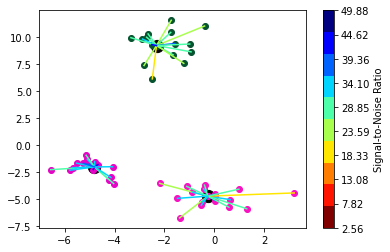

0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.347232


/home/iiitd/.local/lib/python3.8/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/iiitd/.local/lib/python3.8/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/iiitd/.local/lib/python3.8/site-packages/syft/generic/frameworks/hook/hook.py:165: UserWarning: This overload of sub_ is deprecated:
	sub_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	sub_(Tensor other, *, Number alpha) (Triggered internally at  /opt/conda/conda-bld/pytorch_1595629411241/work/torch/csrc/utils/python_arg_parser

Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.318144

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.287144
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.251823

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.292286
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.287711

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.318196
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.305747

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.336403
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.259329

Power Allocated= 4.3367611216775295
CSI= 0.5464517399069008
SNR= 26.17698247

/tmp/ipykernel_680371/1497942811.py:66: RuntimeWarning: invalid value encountered in true_divide
  key_np_received=(key_np_received/(h)).real


Model client39 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.265116

Power Allocated= 5.0502330910122275
CSI= 0.8956433943164716
SNR= 35.454644269557576
Client: client49
Model client49 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.323929
Model client49 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.294183


Test set: Average loss for Cluster1 model: 2.1276, Accuracy: 1615/10000 (16%)

0.14096000000001174
Power Allocated= 0
CSI= 0.07623315043043077
SNR= 21.50404470978232
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.1004399129751423
CSI= 0.2503899064896312
SNR= 27.768590428043385
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.304554
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.320759

Power Allocated= 3.7097192135660824
CSI= 0.2954653243516834
SNR= 22.18539021515297
Client: client10
Model client10 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.278331
Model client10 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.325303

Power Allocated= 6.0800957147311525
CSI= 

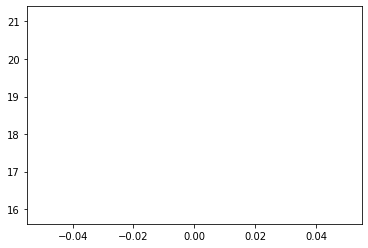

ROUND 0
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.305986
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.294795

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.287247
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.288020

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.303773
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.295800

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.300555
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.292731

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model cli

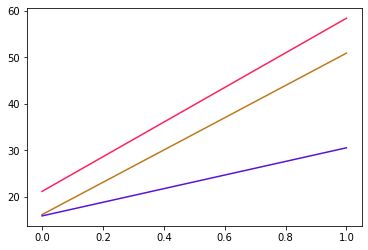

ROUND 1
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.307233
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.294991

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.299850
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.297680

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.294554
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.301309

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.302050
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.299171

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model cli

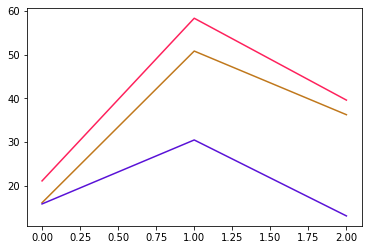

ROUND 2
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.305769
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.290474

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.303272
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.290526

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.299163
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.300291

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.306657
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.303960

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model cli

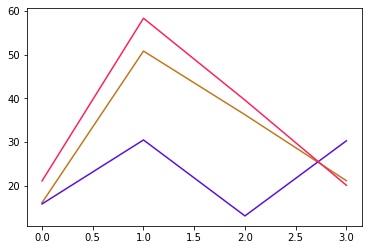

ROUND 3
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.301484
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.287879

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.297979
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.285129

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.289637
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.295992

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.297878
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.298022

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model cli

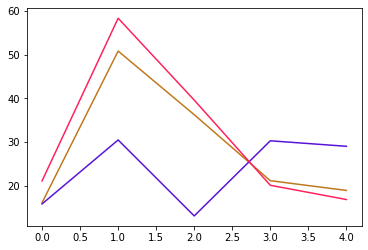

ROUND 4
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.306230
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.264382

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.293324
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.282502

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.295431
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.289345

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.297088
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.282123

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model cli

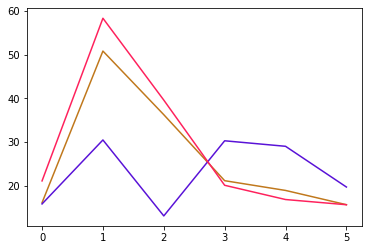

ROUND 5
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.293691
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.249503

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.290051
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.195947

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.294270
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.226347

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.289956
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.242560

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model cli

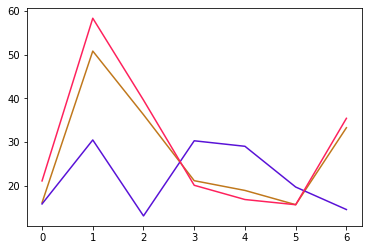

ROUND 6
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.276716
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.046117

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.255590
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.020615

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.268523
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.154034

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.264588
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.992835

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model cli

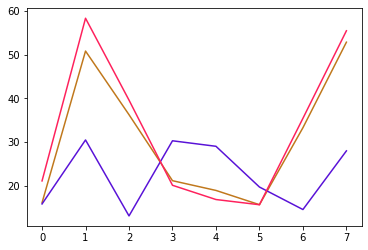

ROUND 7
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.193976
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.516877

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.187091
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.762325

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.189264
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.686855

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.189807
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.624636

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model cli

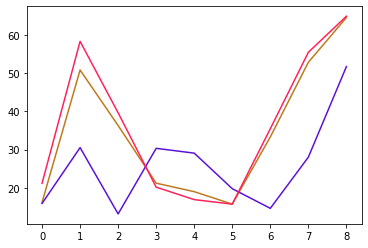

ROUND 8
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.031619
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.381854

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.020765
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.679153

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.015061
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.593075

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.029597
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.485171

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model cli

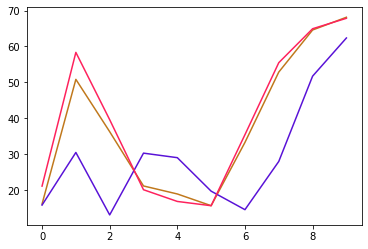

ROUND 9
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.791460
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.620925

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.752482
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.348252

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.776772
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.493323

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.762387
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.393472

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model cli

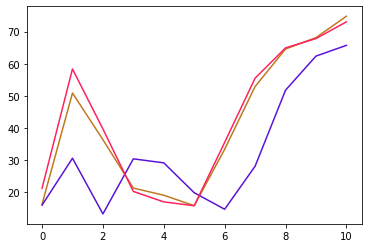

ROUND 10
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.736549
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.416007

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.877269
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.101070

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.848469
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.279162

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.782664
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.312080

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model cl

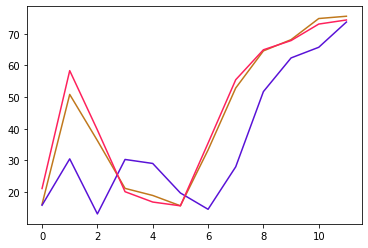

ROUND 11
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.834229
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.081362

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.789920
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.023080

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.855687
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.018026

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.764118
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.248293

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model cl

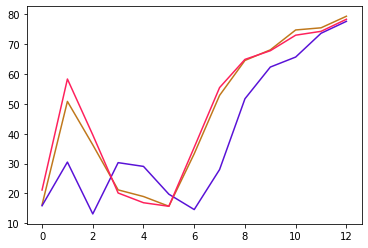

ROUND 12
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.321597
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.067098

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.481484
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.666119

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.428183
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.272281

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.352028
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.226961

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model cl

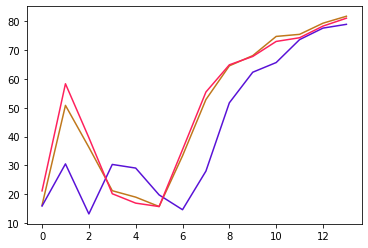

ROUND 13
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.451134
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.216659

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.308580
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.927892

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.313849
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.848176

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.503784
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.248937

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model cl

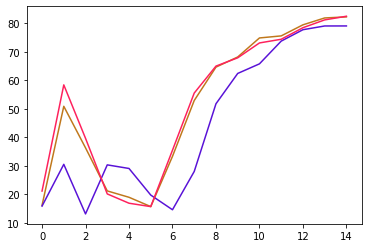

ROUND 14
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.393986
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.794706

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.367127
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.774983

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.411161
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.112771

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.320637
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.947933

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model cl

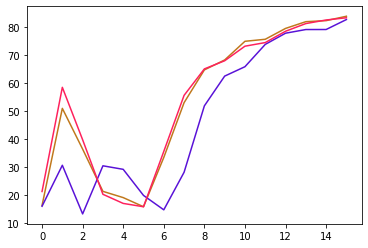

ROUND 15
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.974774
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.880871

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.163718
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.726859

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.068772
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.785211

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.053993
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.295353

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model cl

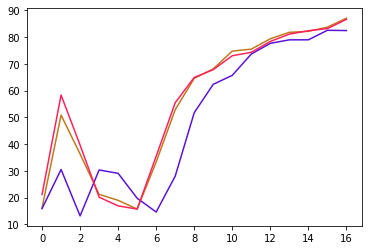

ROUND 16
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.127073
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.930033

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.043734
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.713870

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.010882
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.723624

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.970887
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.725425

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model cl

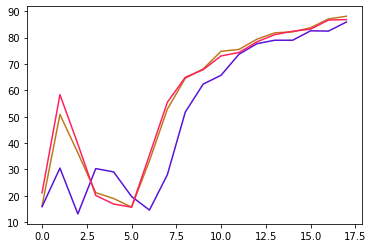

ROUND 17
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.130097
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.642504

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.119716
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.600127

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.006482
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.673476

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.877938
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.471320

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model cl

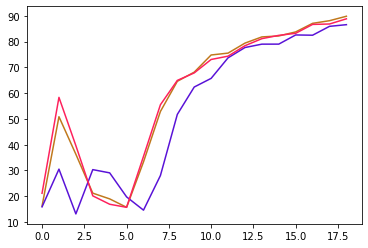

ROUND 18
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.911277
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.414338

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.904772
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.871413

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.861950
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.816179

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.874157
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.560784

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model cl

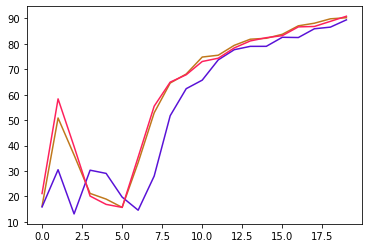

ROUND 19
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.831379
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.618327

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.796586
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.526724

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.996696
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.727870

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.771380
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.573055

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model cl

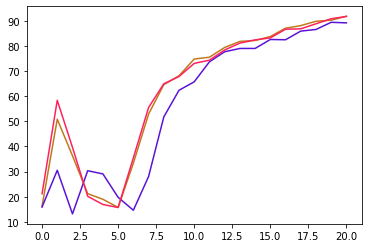

ROUND 20
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.803745
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.467178

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.944494
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.585302

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.795048
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.552344

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.786326
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.589970

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model cl

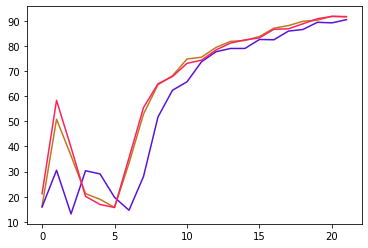

ROUND 21
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.923007
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.759779

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.782874
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.551962

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.875648
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.723931

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.776562
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.282905

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model cl

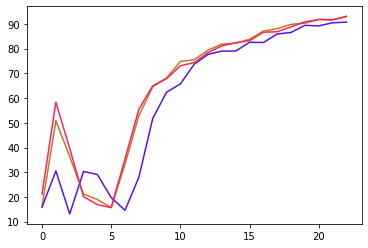

ROUND 22
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.852429
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.495409

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.574581
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.463622

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.676014
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.309939

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.769555
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.395631

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model cl

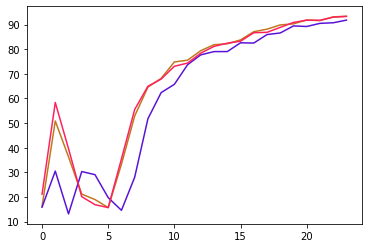

ROUND 23
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.835020
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.547807

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.802105
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.328259

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.814193
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.477277

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.976419
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.596062

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model cl

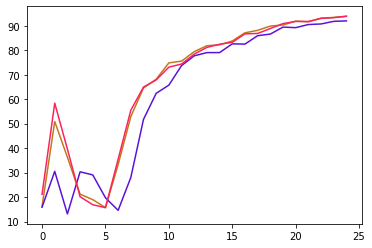

ROUND 24
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.604855
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.411869

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.646236
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.281538

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.673102
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.344533

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.833266
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.439260

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model cl

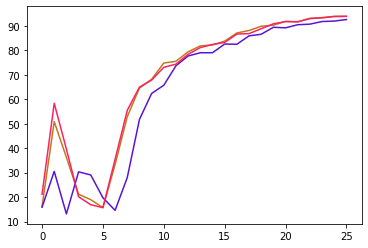

ROUND 25
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.629533
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.383247

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.557319
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.424648

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.599082
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.405939

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.666886
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.591567

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model cl

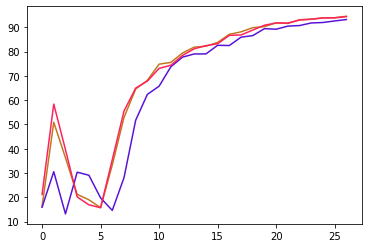

ROUND 26
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.741496
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.392096

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.718627
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.564491

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.825442
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.420055

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.816888
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.544353

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model cl

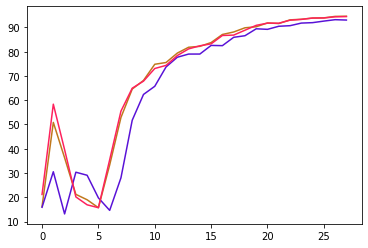

ROUND 27
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.960491
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.369924

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.923389
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.689979

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.042791
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.532357

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.985154
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.305322

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model cl

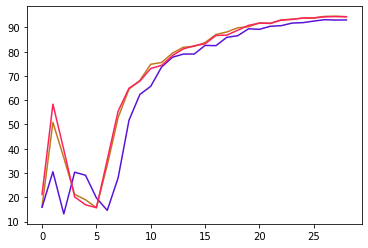

ROUND 28
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.696387
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.512742

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.463624
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.149909

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.754769
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.209954

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.512051
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.468803

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model cl

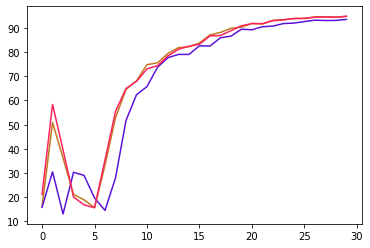

ROUND 29
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.539988
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.256740

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.462979
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.370403

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.643594
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.436569

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.738595
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.307251

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model cl

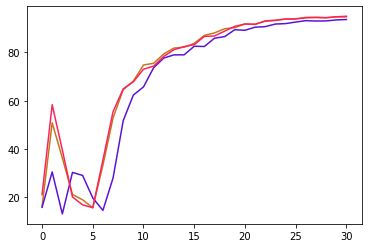

ROUND 30
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.608545
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.473591

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.570454
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.434261

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.620890
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.302057

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.664170
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.551490

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model cl

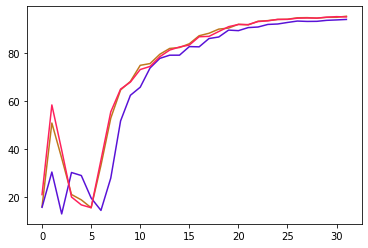

ROUND 31
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.530379
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.276776

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.566701
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.524348

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.526253
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.379025

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.585876
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.588987

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model cl

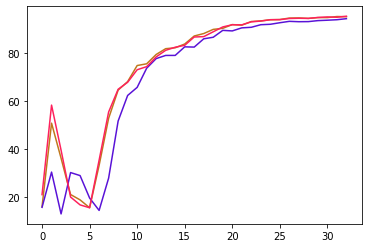

ROUND 32
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.627372
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.453028

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.678105
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.553016

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.601022
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.157945

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.708770
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.710076

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model cl

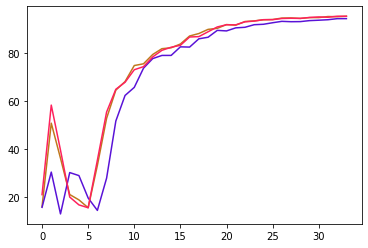

ROUND 33
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.641216
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.141141

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.536249
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.272424

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.607065
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.374755

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.519799
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.576277

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model cl

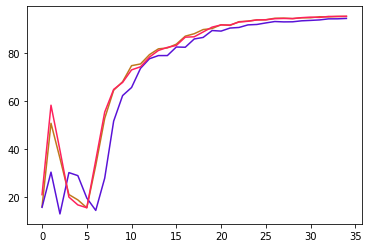

ROUND 34
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.663358
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.317729

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.676475
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.379021

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.570460
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.330505

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.591474
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.558392

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model cl

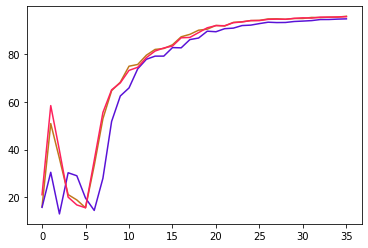

ROUND 35
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.543343
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.345118

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.586690
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.225136

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.558780
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.480701

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.723185
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.370516

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model cl

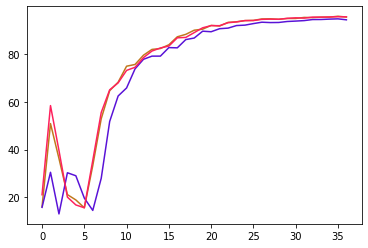

ROUND 36
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.608167
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.466462

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.675174
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.468437

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.574214
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.246679

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.597582
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.353935

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model cl

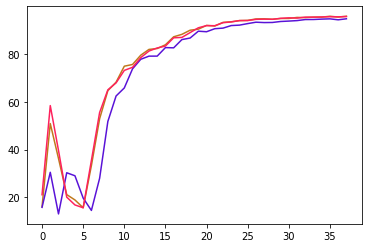

ROUND 37
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.562285
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.248498

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.717762
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.174004

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.560216
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.226155

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.621862
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.503185

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model cl

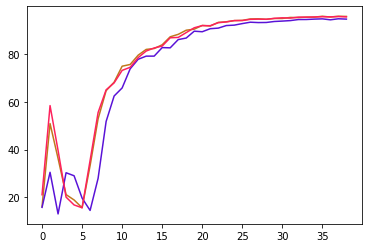

ROUND 38
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.462976
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.298625

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.416443
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.176443

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.376251
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.253160

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.359461
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.376982

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model cl

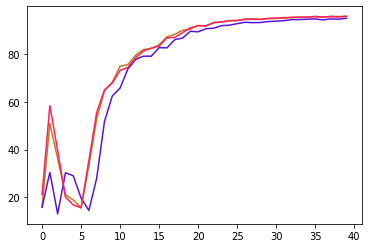

ROUND 39
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.629184
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.441406

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.435326
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.381931

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.530526
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.201940

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.571762
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.382622

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model cl

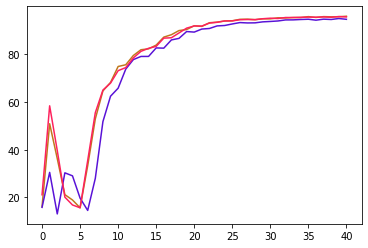

ROUND 40
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.635066
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.281368

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.588925
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.184610

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.690652
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.468478

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.570915
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.243987

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model cl

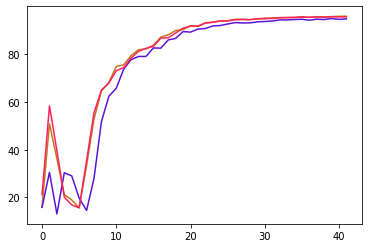

ROUND 41
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.542296
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.334062

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.421854
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.365000

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.390631
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.228611

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.412911
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.251091

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model cl

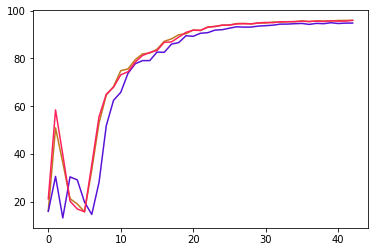

ROUND 42
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.446049
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.254308

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.485243
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.188897

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.574331
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.278585

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.543142
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.427202

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model cl

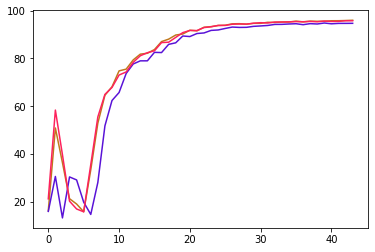

ROUND 43
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.378733
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.237850

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.439292
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.140238

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.468366
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.460739

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.470309
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.147360

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model cl

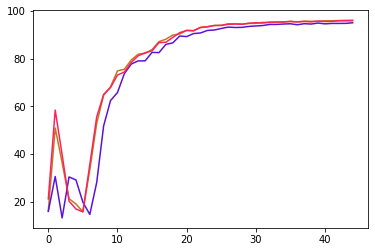

ROUND 44
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.415993
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.277369

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.414867
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.263950

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.354397
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.334796

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.473892
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.132596

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model cl

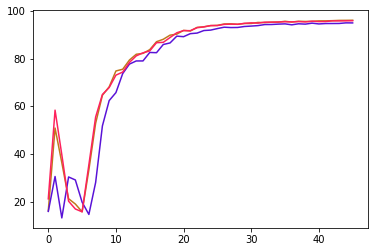

ROUND 45
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.354654
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.248195

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.503004
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.188136

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.389730
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.230386

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.355264
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.226310

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model cl

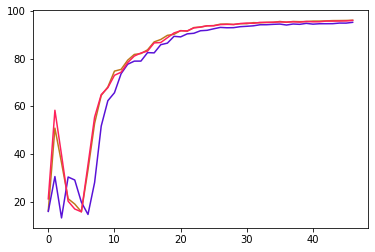

ROUND 46
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.640001
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.266336

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.616395
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.149300

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.581622
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.186706

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.551328
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.320737

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model cl

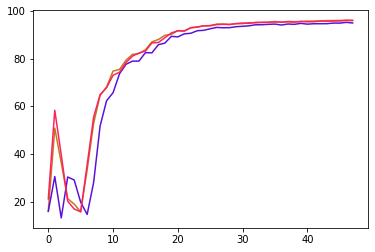

ROUND 47
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.433004
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.390040

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.392856
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.239343

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.445133
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.171904

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.498401
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.339175

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model cl

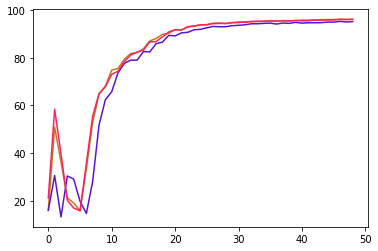

ROUND 48
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.494727
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.120941

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.441928
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.075569

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.569456
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.176504

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.482950
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.181676

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model cl

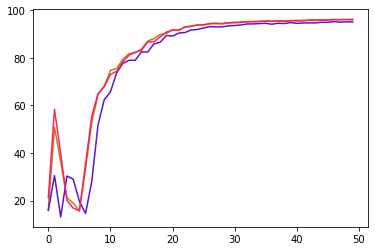

ROUND 49
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.489251
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.112165

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.302854
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.181326

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.453035
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.329553

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.405277
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.136750

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model cl

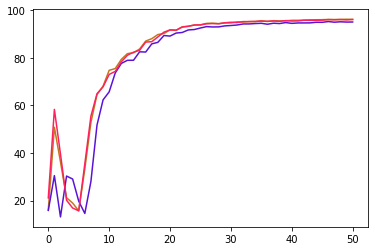

ROUND 50
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.441999
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.134040

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.547420
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.236033

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.395960
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.138399

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.417010
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.164656

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model cl

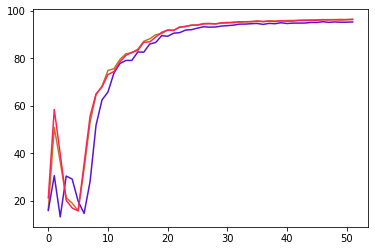

ROUND 51
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.466717
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.105944

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.301774
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.161107

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.333079
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.163776

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.288697
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.072426

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model cl

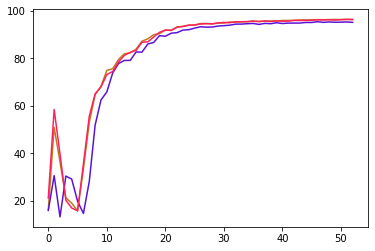

ROUND 52
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.363379
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.206892

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.498021
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.348040

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.332170
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.225477

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.409682
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.156059

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model cl

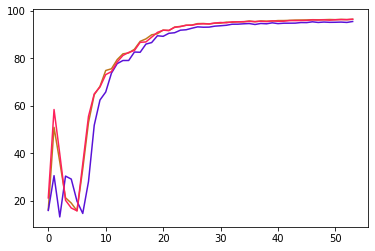

ROUND 53
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.458573
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.223893

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.400725
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.161299

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.435481
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.189148

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.413545
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.218914

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model cl

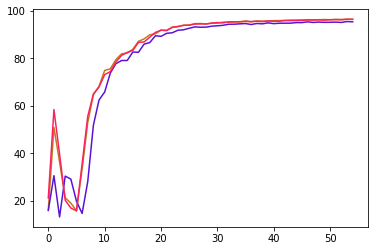

ROUND 54
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.439207
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.149770

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.367273
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.179009

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.401808
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.119323

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.219972
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.108129

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model cl

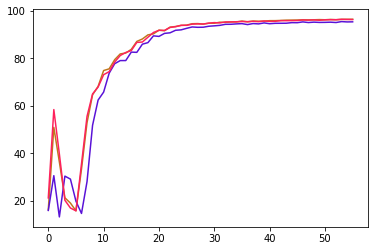

ROUND 55
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.351424
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.164687

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.452128
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.099436

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.463389
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.182175

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.504130
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.318569

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model cl

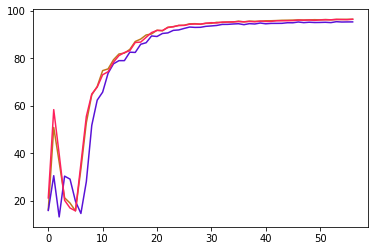

ROUND 56
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.333403
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.170853

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.364769
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.275977

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.357621
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.109623

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.461333
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.177463

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model cl

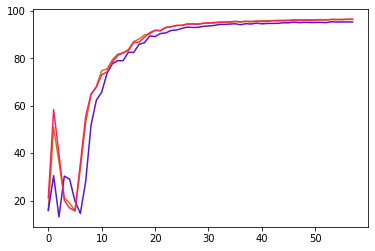

ROUND 57
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.230116
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.120815

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.217496
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.180089

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.262249
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.321892

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.487463
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.072404

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model cl

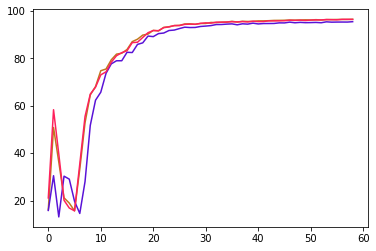

ROUND 58
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.396017
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.053227

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.327601
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.252406

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.304969
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.342288

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.416776
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.112197

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model cl

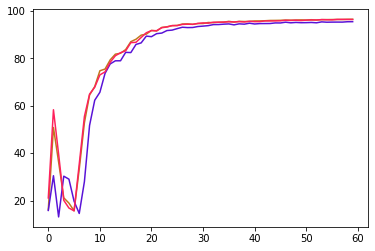

ROUND 59
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.371145
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.198950

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.329535
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.147727

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.327699
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.215321

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.307043
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.079067

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model cl

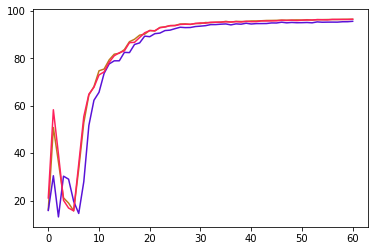

ROUND 60
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.563563
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.207019

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.492652
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.094147

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.552128
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.178644

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.626395
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.352898

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model cl

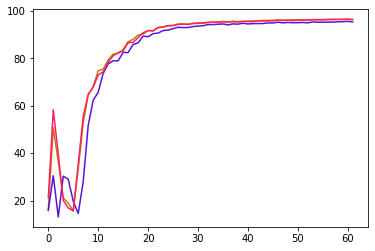

ROUND 61
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.341969
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.198102

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.527507
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.099405

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.397955
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.157243

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.410407
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.192172

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model cl

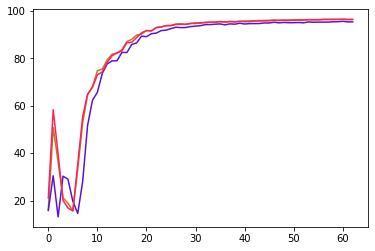

ROUND 62
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.208501
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.115044

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.256326
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.181111

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.311028
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.170251

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.443299
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.277873

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model cl

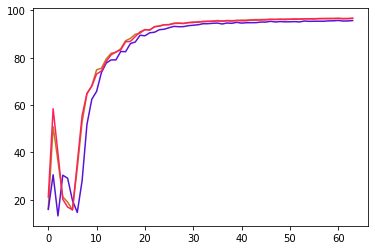

ROUND 63
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.245632
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.345100

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.206979
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.043512

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.363821
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.151827

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.540847
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.101198

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model cl

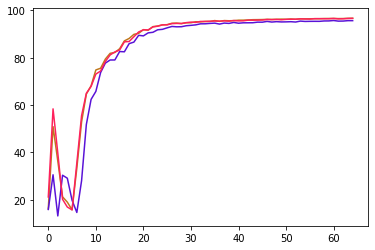

ROUND 64
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.321771
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.070737

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.253797
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.142046

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.361577
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.223185

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.365417
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.156574

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model cl

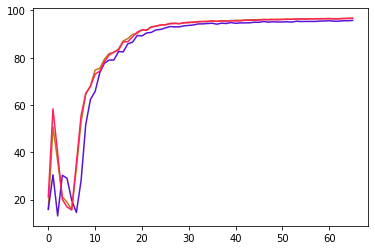

ROUND 65
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.326892
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.076620

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.360077
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.130599

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.492312
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.221388

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.345686
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.294272

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model cl

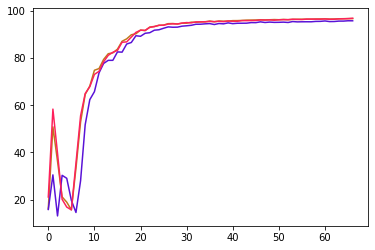

ROUND 66
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.403281
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.160121

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.504359
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.099020

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.458380
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.178071

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.565801
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.160289

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model cl

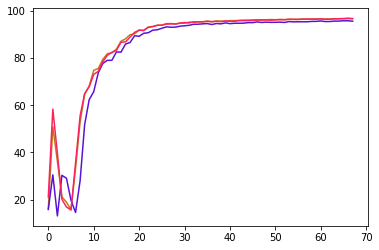

ROUND 67
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.423963
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.143506

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.369529
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.252990

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.246070
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.335769

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.390866
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.064963

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model cl

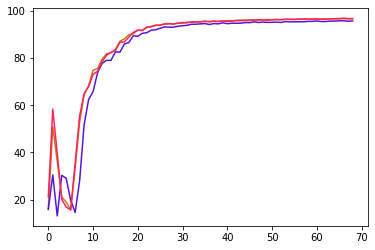

ROUND 68
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.337971
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.048408

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.291722
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.437393

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.335137
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.143208

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.316799
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.375248

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model cl

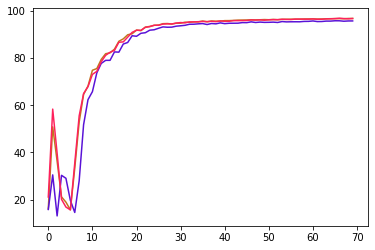

ROUND 69
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.263232
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.064630

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.324786
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.231144

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.411634
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.253243

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.259332
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.197138

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model cl

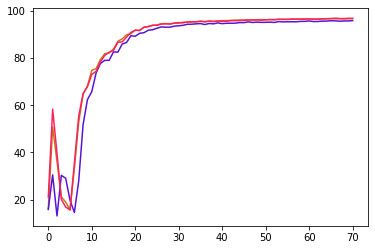

ROUND 70
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.375683
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.137671

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.474812
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.120688

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.432793
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.222048

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.712384
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.147883

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model cl

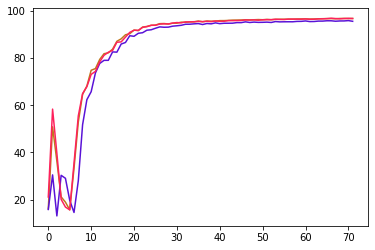

ROUND 71
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.270008
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.263017

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.348272
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.167070

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.387543
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.028697

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.350904
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.145376

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model cl

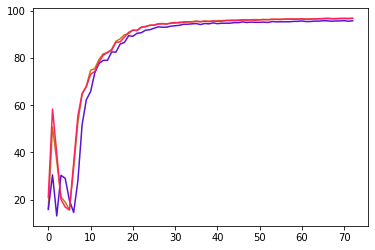

ROUND 72
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.317428
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.174753

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.252148
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.114984

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.360484
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.257690

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.309748
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.177037

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model cl

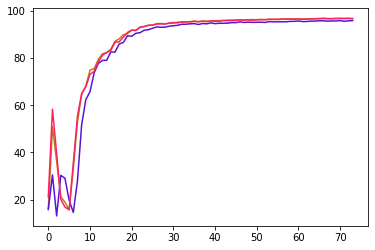

ROUND 73
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.208822
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.250394

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.310612
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.182292

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.325441
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.128197

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.288121
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.313092

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model cl

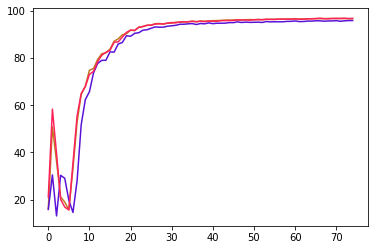

ROUND 74
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.200381
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.185484

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.217699
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.055026

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.222836
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.246866

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.188513
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.157370

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model cl

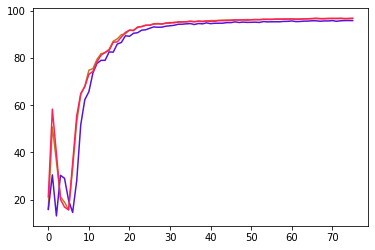

ROUND 75
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.311459
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.176214

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.414681
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.109783

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.509209
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.154689

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.236121
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.139636

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model cl

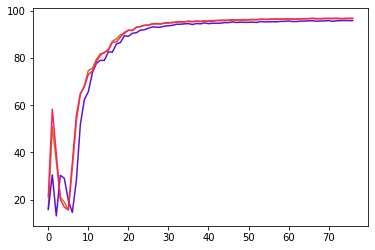

ROUND 76
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.473080
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.130546

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.449947
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.416934

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.434658
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.042095

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.395441
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.112976

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model cl

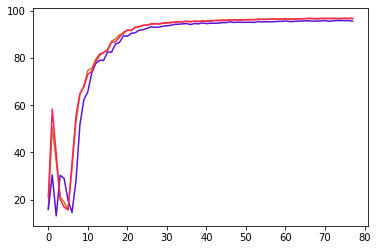

ROUND 77
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.206970
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.248067

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.209713
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.084112

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.276365
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.236906

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.367609
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.055075

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model cl

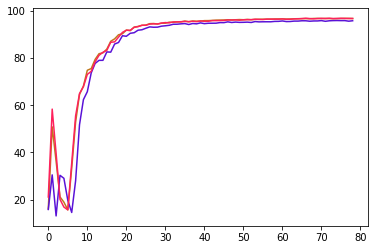

ROUND 78
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.189079
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.091051

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.180078
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.207510

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.233571
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.222134

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.279318
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.086747

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model cl

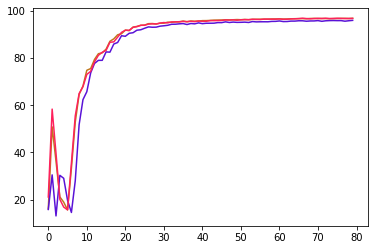

ROUND 79
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.324945
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.058534

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.382018
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.280752

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.403686
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.144873

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.256195
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.111021

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model cl

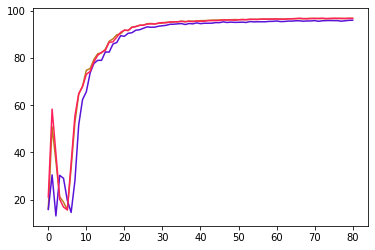

ROUND 80
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.320313
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.061426

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.143178
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.198609

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.260472
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.260423

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.277389
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.071412

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model cl

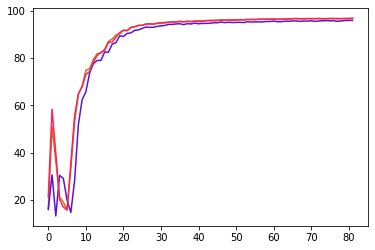

ROUND 81
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.186128
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.126542

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.249666
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.329663

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.325006
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.119182

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.144443
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.173888

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model cl

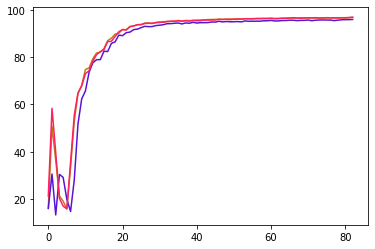

ROUND 82
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.396502
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.219301

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.319925
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.204960

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.316488
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.067358

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.396744
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.162787

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model cl

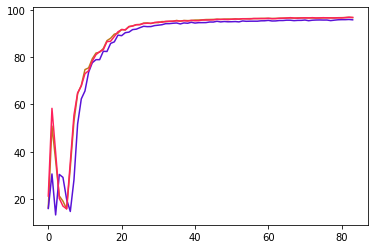

ROUND 83
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.310391
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.127980

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.219805
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.070553

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.191624
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.154072

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.327222
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.064871

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model cl

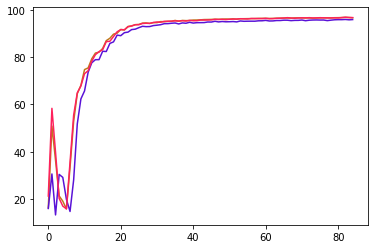

ROUND 84
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.406861
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.181192

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.318630
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.297576

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.413182
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.010149

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.172567
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.083495

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model cl

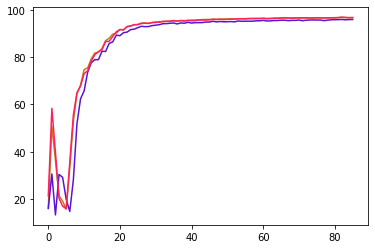

ROUND 85
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.364961
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.190862

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.402897
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.105936

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.268668
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.045999

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.371985
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.261726

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model cl

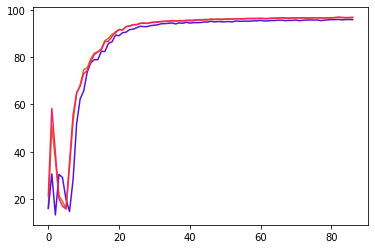

ROUND 86
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.327114
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.086051

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.364226
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.026268

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.199169
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.107920

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.253861
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.072589

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model cl

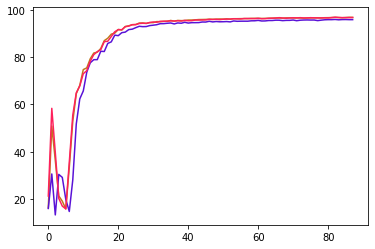

ROUND 87
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.209488
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.205846

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.225027
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.088608

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.375107
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.082286

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.240734
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.048520

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model cl

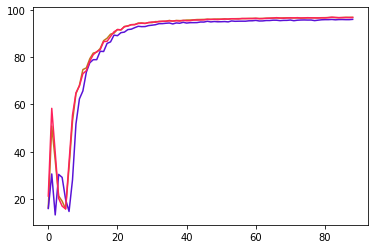

ROUND 88
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.320177
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.072338

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.324133
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.164225

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.292516
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.090175

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.396879
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.246562

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model cl

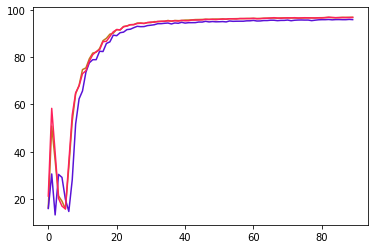

ROUND 89
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.409333
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.081543

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.393962
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.120692

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.250378
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.118774

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.294280
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.166969

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model cl

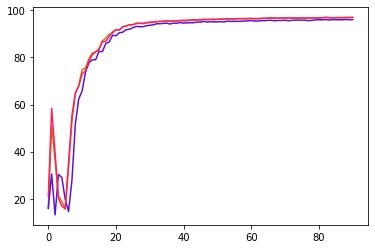

ROUND 90
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.462197
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.136705

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.294964
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.093799

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.276426
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.130398

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.268954
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.165044

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model cl

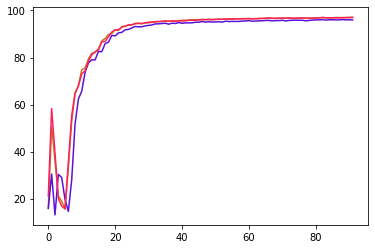

ROUND 91
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.364991
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.065295

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.205256
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.055689

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.301436
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.163395

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.322529
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.193606

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model cl

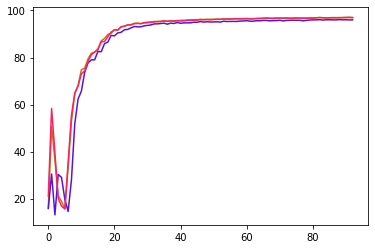

ROUND 92
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.237928
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.037561

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.178217
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.103367

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.214173
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.153204

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.275694
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.137963

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model cl

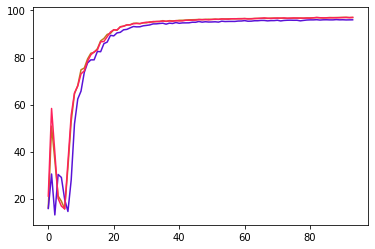

ROUND 93
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.450774
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.210783

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.303990
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.070407

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.243085
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.073655

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.289648
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.088549

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model cl

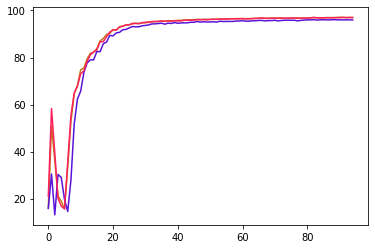

ROUND 94
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.272828
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.137400

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.278446
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.132997

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.257015
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.003615

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.260466
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.087580

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model cl

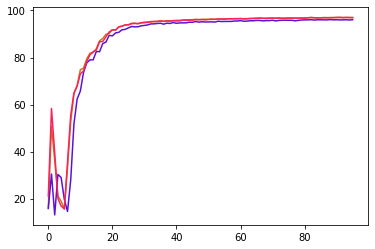

ROUND 95
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.281781
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.086140

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.259016
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.133016

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.296727
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.120639

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.359034
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.121295

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model cl

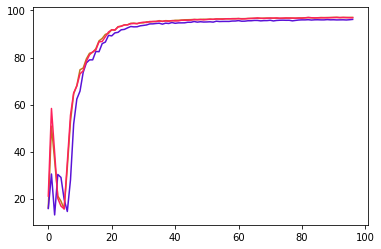

ROUND 96
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.245151
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.196569

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.325193
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.151314

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.258489
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.170939

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.172827
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.132048

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model cl

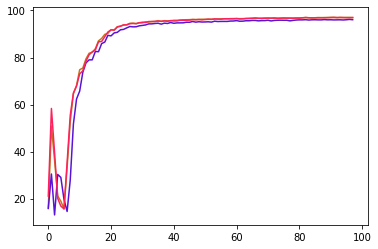

ROUND 97
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.356658
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.253666

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.242342
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.159288

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.206380
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.247478

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.272682
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.101546

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model cl

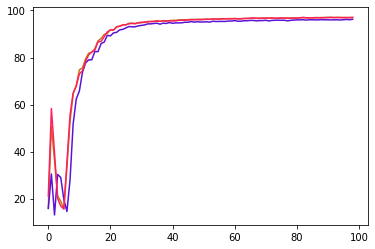

ROUND 98
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.286556
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.092029

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.292290
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.096507

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.350814
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.286506

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.256092
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.213395

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model cl

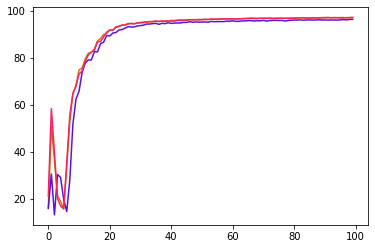

ROUND 99
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.234652
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.055889

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.189500
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.041769

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.478190
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.226550

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.283161
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.106146

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model cl

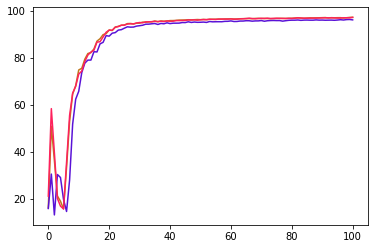

ROUND 100
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.151468
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.103686

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.191972
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.050304

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.154532
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.191669

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.278867
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.020265

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model c

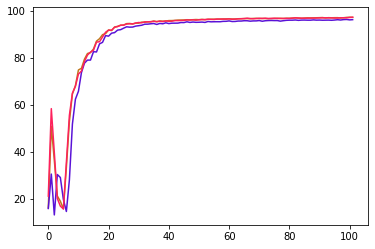

ROUND 101
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.182185
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.182735

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.150999
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.214809

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.300523
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.181778

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.274238
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.034768

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model c

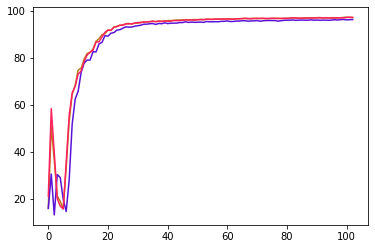

ROUND 102
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.268630
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.146564

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.263443
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.113884

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.346291
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.174029

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.298981
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.149633

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model c

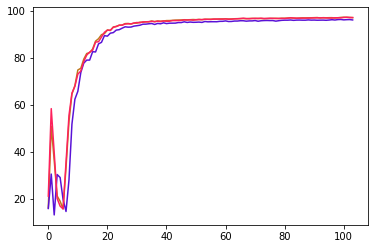

ROUND 103
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.257032
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.039738

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.231829
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.123452

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.245747
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.074074

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.144037
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.140854

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model c

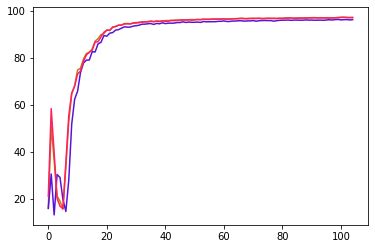

ROUND 104
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.184670
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.111211

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.285443
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.103098

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.233790
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.109498

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.333037
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.177714

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model c

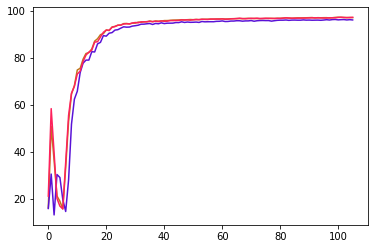

ROUND 105
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.195275
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.116571

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.377572
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.020952

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.242060
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.055861

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.450447
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.198385

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model c

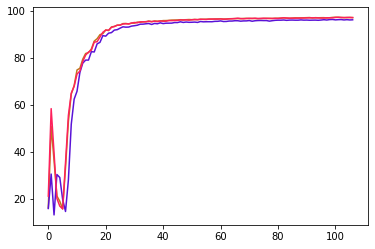

ROUND 106
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.431865
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.084040

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.144931
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.158930

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.351238
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.097795

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.272150
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.225771

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model c

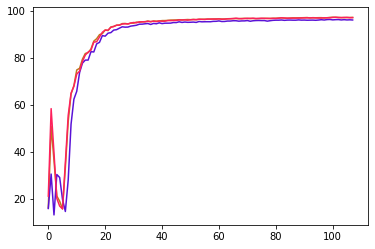

ROUND 107
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.246601
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.016733

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.314120
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.130498

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.271291
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.137705

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.383318
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.062499

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model c

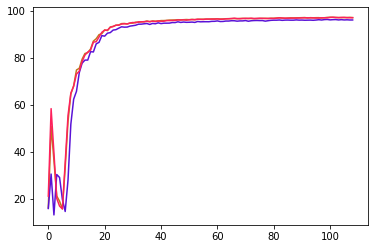

ROUND 108
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.508932
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.141144

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.329059
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.048185

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.364258
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.207306

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.273336
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.296067

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model c

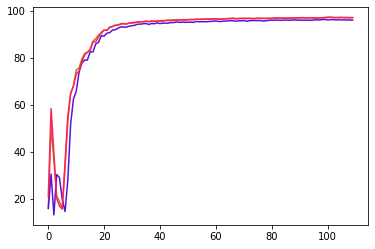

ROUND 109
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.199613
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.024363

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.286425
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.038443

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.270769
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.077984

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.398625
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.170747

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model c

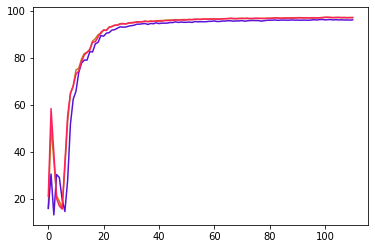

ROUND 110
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.230828
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.139777

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.171128
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.156157

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.304394
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.052174

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.160719
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.159985

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model c

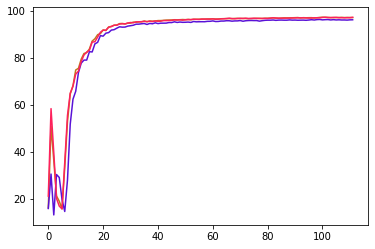

ROUND 111
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.151457
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.049969

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.235977
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.176768

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.221656
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.133364

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.183803
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.097788

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model c

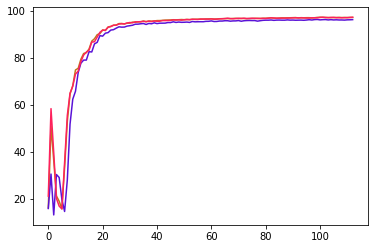

ROUND 112
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.400047
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.046892

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.248283
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.089832

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.139987
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.138495

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.210905
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.155081

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model c

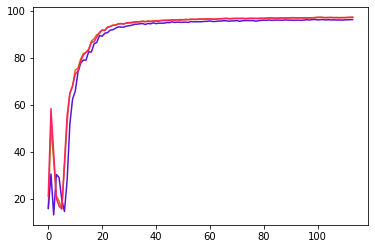

ROUND 113
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.207812
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.120484

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.256507
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.128375

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.141523
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.082884

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.357656
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.052241

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model c

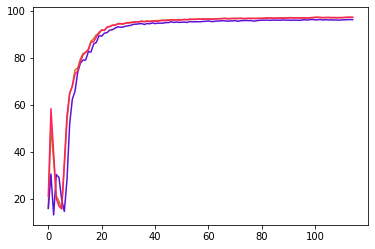

ROUND 114
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.514787
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.047664

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.427313
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.127123

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.587621
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.096866

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.499694
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.104440

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model c

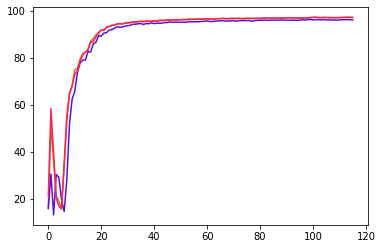

ROUND 115
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.307419
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.039091

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.389407
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.060686

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.361288
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.246699

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.506714
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.146301

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model c

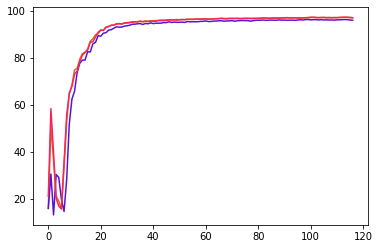

ROUND 116
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.257430
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.051526

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.208603
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.079330

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.301615
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.077343

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.352123
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.116591

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model c

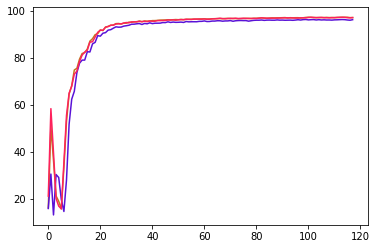

ROUND 117
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.177343
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.145893

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.379522
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.246668

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.350486
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.066286

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.255333
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.016035

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model c

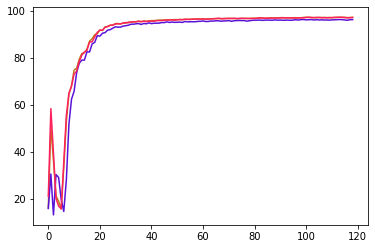

ROUND 118
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.272333
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.016283

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.324424
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.058617

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.204347
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.086053

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.230055
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.394280

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model c

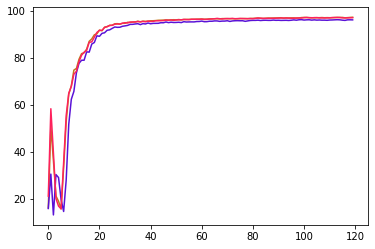

ROUND 119
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.216919
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.032215

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.149448
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.189817

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.112860
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.008203

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.159114
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.084442

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model c

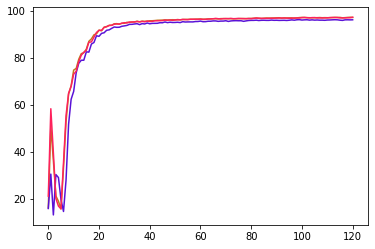

ROUND 120
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.150900
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.043438

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.157640
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.046809

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.281960
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.131935

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.502796
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.142293

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model c

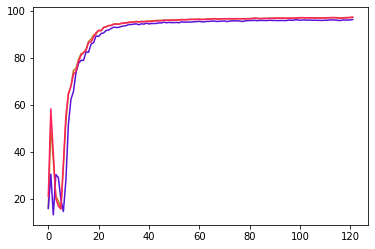

ROUND 121
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.264149
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.021938

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.171778
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.113198

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.297042
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.104195

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.297348
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.070759

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model c

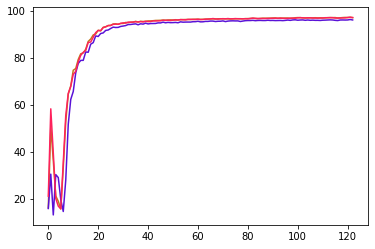

ROUND 122
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.340510
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.058937

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.261631
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.052887

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.338795
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.077172

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.497597
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.089384

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model c

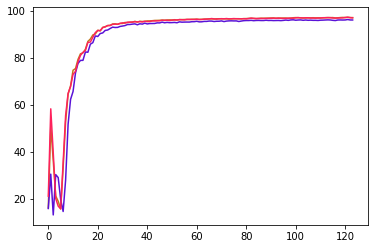

ROUND 123
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.256935
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.046641

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.297835
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.167384

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.263350
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.078034

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.236081
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.049719

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model c

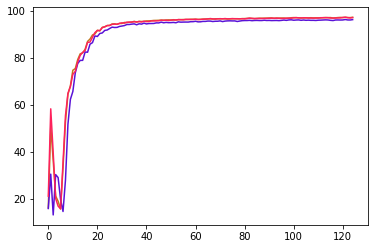

ROUND 124
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.139676
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.072892

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.205777
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.085959

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.217450
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.037275

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.281657
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.088713

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model c

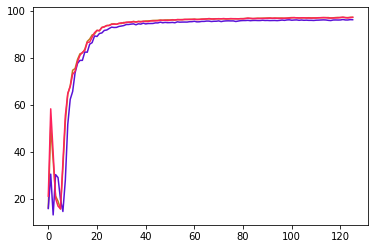

ROUND 125
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.262065
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.042921

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.120005
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.147753

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.138033
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.227832

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.327191
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.165809

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model c

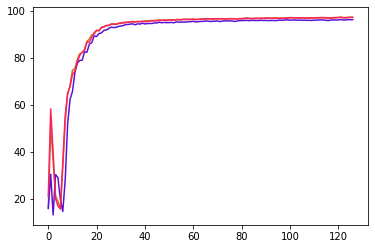

ROUND 126
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.350716
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.270042

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.344335
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.028712

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.364106
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.038634

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.279703
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.072735

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model c

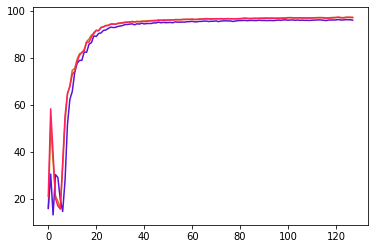

ROUND 127
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.269579
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.059687

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.331628
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.055490

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.296264
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.055208

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.292787
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.121892

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model c

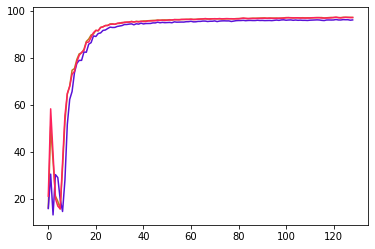

ROUND 128
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.310766
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.065875

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.420809
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.134673

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.220951
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.256613

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.185904
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.141913

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model c

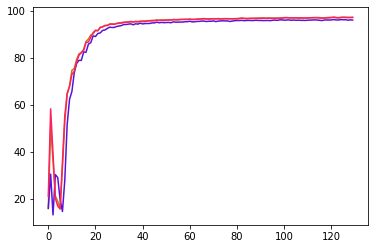

ROUND 129
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.273411
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.105300

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.269655
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.095837

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.332415
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.133888

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.232129
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.231482

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model c

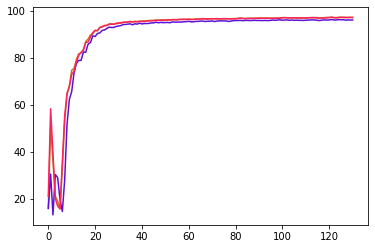

ROUND 130
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.330265
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.073858

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.114334
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.328369

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.207077
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.261596

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.257955
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.163293

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model c

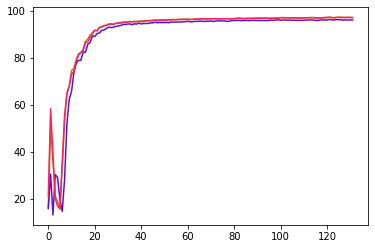

ROUND 131
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.273654
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.028984

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.229907
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.180393

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.292542
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.031567

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.342428
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.068820

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model c

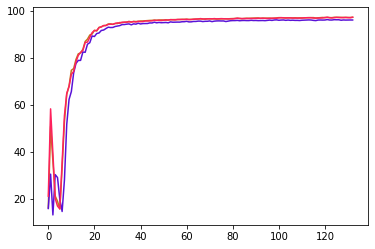

ROUND 132
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.289221
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.070844

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.406568
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.048473

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.386058
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.254329

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.475541
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.104228

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model c

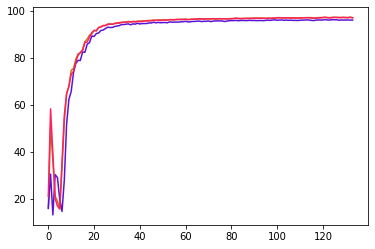

ROUND 133
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.160892
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.005499

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.216644
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.087983

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.231233
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.351109

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.396677
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.053842

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model c

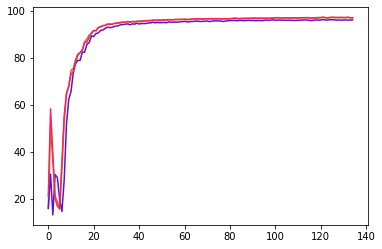

ROUND 134
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.090729
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.288143

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.167816
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.023900

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.251817
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.123082

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.308769
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.059580

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model c

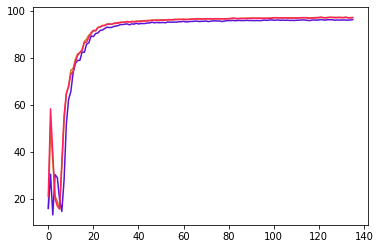

ROUND 135
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.223422
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.028324

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.344403
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.093040

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.142539
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.078292

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.201435
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.209763

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model c

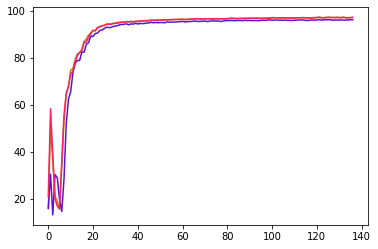

ROUND 136
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.439117
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.181218

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.361590
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.129765

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.363292
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.115926

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.468308
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.053803

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model c

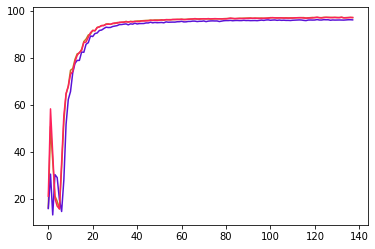

ROUND 137
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.328968
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.076634

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.167794
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.245228

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.222475
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.089562

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.223913
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.174285

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model c

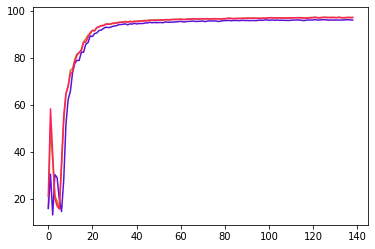

ROUND 138
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.290474
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.099754

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.187656
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.022059

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.214306
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.004246

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.273523
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.224358

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model c

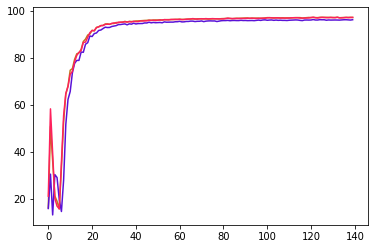

ROUND 139
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.138078
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.298329

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.334892
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.153521

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.204590
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.164364

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.157565
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.127023

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model c

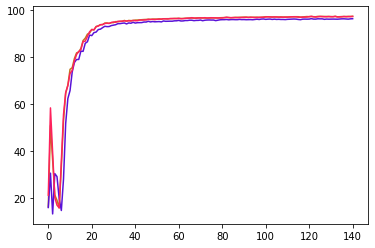

ROUND 140
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.220128
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.104741

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.245916
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.013176

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.179014
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.053694

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.256550
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.115481

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model c

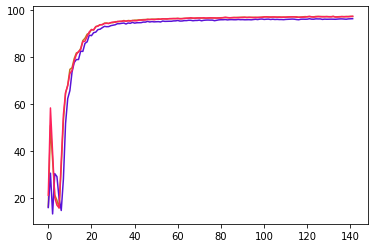

ROUND 141
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.330646
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.013826

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.242903
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.087188

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.300573
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.046397

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.484783
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.116003

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model c

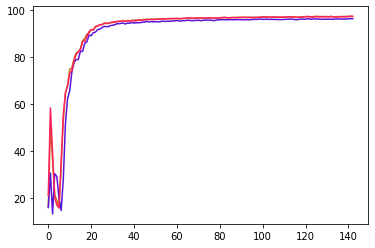

ROUND 142
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.329255
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.324432

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.170334
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.083341

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.224849
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.026688

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.445523
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.089639

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model c

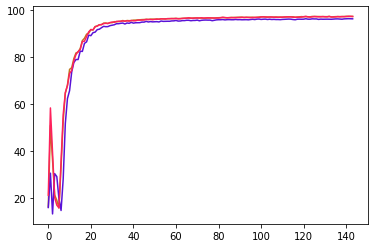

ROUND 143
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.237169
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.243396

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.298909
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.173603

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.158432
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.148909

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.184758
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.135597

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model c

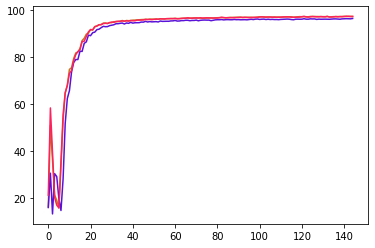

ROUND 144
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.172874
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.043494

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.363117
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.387330

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.325210
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.161223

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.306701
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.054653

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model c

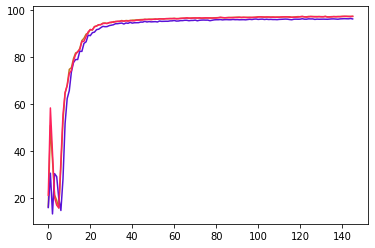

ROUND 145
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.172731
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.040636

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.225208
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.073938

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.250923
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.052574

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.313738
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.050994

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model c

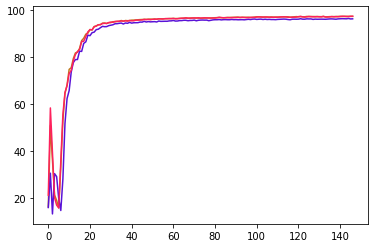

ROUND 146
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.219132
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.090758

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.171231
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.031977

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.260529
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.088737

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.383090
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.079427

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model c

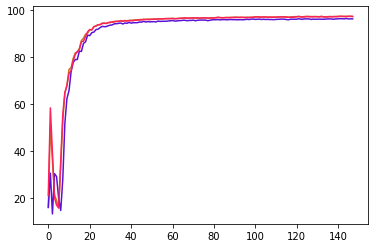

ROUND 147
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.278155
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.089709

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.248566
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.057368

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.060792
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.061303

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.160952
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.045706

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model c

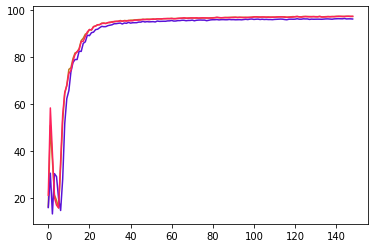

ROUND 148
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.186810
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.020294

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.240921
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.021466

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.124019
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.038040

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.326854
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.042179

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model c

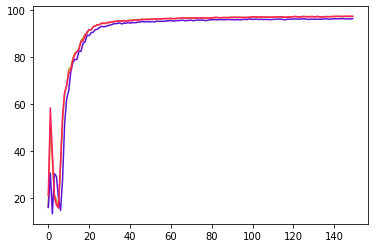

ROUND 149
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.202884
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.014215

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.225348
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.114773

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.214207
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.134130

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.408752
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.058292

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model c

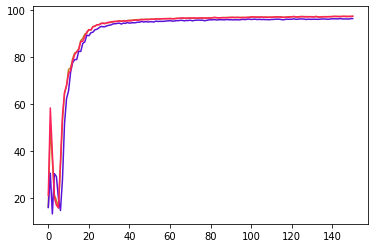

ROUND 150
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.167261
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.043326

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.216748
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.113050

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.503048
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.012543

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.113955
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.140063

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model c

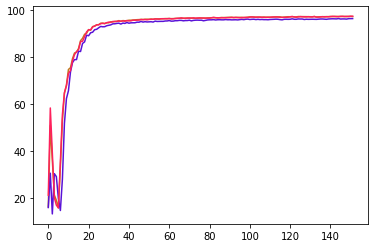

ROUND 151
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.208740
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.152843

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.235398
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.147404

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.111141
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.194821

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.210084
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.173153

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model c

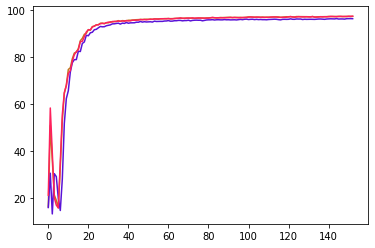

ROUND 152
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.197375
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.099235

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.221033
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.174180

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.203378
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.046026

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.245803
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.066132

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model c

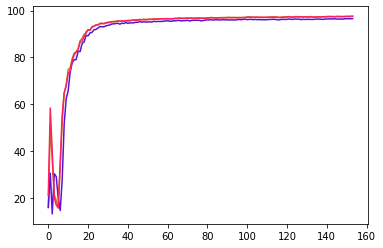

ROUND 153
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.169585
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.084000

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.188090
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.056216

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.168525
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.059284

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.245691
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.189367

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model c

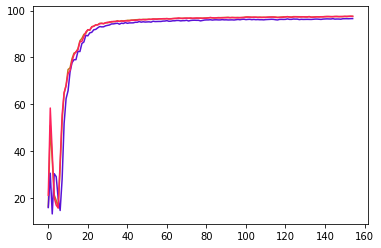

ROUND 154
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.173891
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.079149

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.192992
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.015440

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.196953
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.081008

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.189875
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.124730

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model c

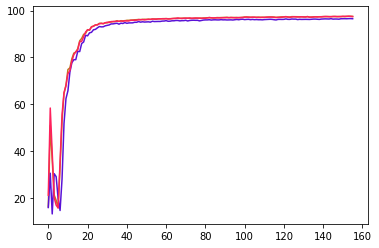

ROUND 155
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.306775
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.038295

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.196611
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.070101

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.275103
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.033458

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.261534
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.057957

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model c

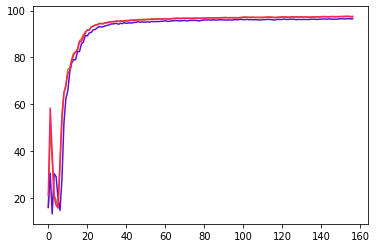

ROUND 156
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.157346
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.136635

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.206746
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.016962

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.142288
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.065331

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.326017
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.022787

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model c

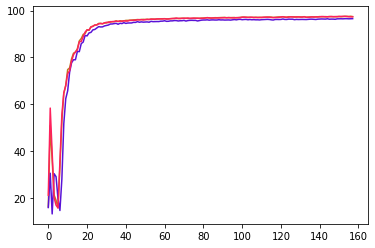

ROUND 157
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.229788
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.119048

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.270739
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.097491

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.274657
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.110502

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.188189
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.030093

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model c

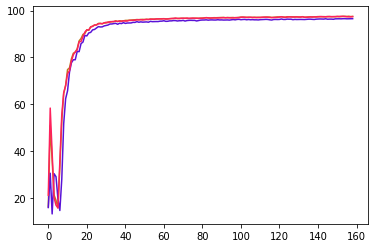

ROUND 158
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.284606
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.054295

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.137123
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.028788

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.220532
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.043517

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.157861
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.141332

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model c

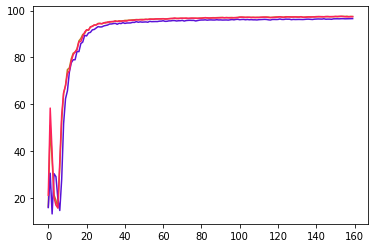

ROUND 159
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.293489
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.064938

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.148341
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.053370

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.239818
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.115166

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.204337
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.047937

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model c

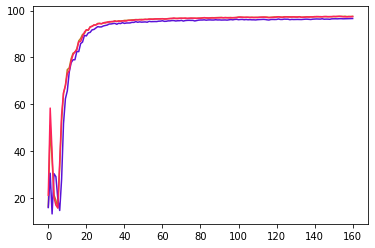

ROUND 160
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.166595
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.183857

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.175575
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.023429

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.345633
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.008373

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.257543
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.171089

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model c

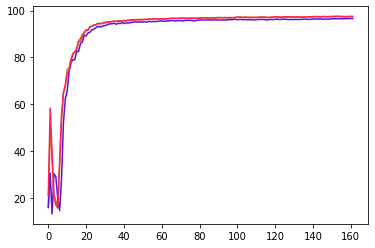

ROUND 161
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.176878
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.083057

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.108796
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.078287

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.169435
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.061535

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.135478
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.028000

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model c

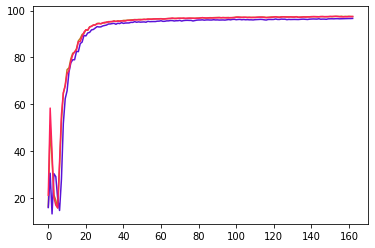

ROUND 162
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.276661
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.082122

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.165811
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.022544

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.159818
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.061659

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.234522
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.140049

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model c

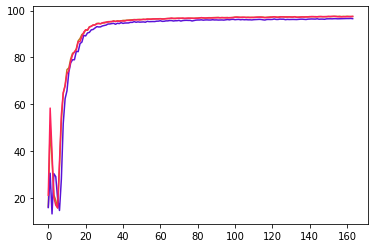

ROUND 163
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.281582
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.049305

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.262149
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.071040

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.228139
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.037984

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.341431
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.150307

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model c

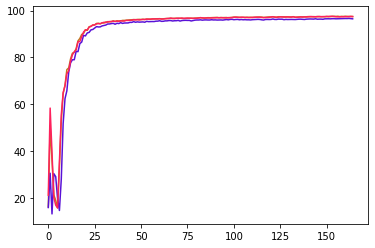

ROUND 164
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.191017
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.046539

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.174884
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.034202

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.305611
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.064616

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.249476
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.013151

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model c

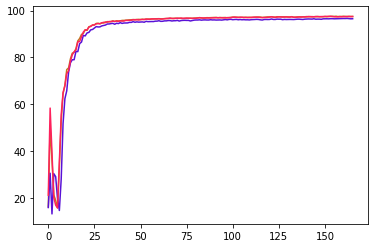

ROUND 165
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.359910
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.035402

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.239141
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.148424

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.332213
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.027748

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.227014
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.045004

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model c

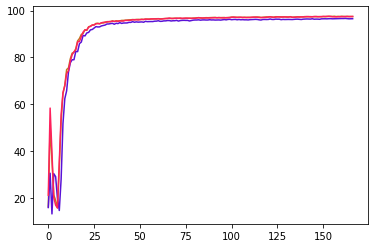

ROUND 166
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.229805
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.177381

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.184629
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.018113

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.083264
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.240949

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.192311
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.067324

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model c

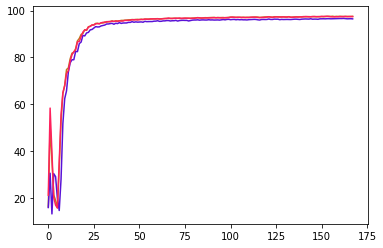

ROUND 167
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.205321
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.015041

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.122700
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.015957

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.187515
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.068679

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.210199
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.110984

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model c

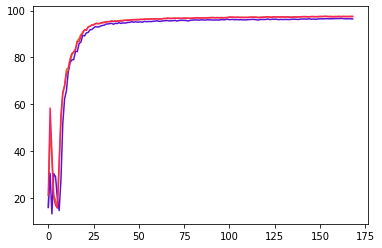

ROUND 168
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.319887
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.052589

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.370099
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.109039

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.357421
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.170568

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.304491
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.108254

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model c

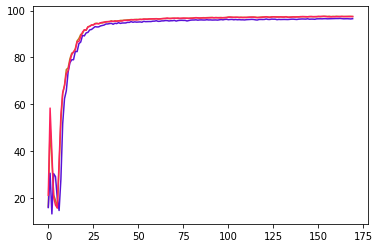

ROUND 169
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.335972
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.037849

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.189206
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.071812

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.350243
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.093945

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.219088
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.094740

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model c

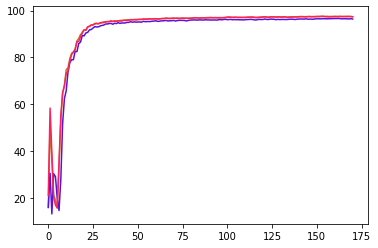

ROUND 170
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.149867
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.016843

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.194746
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.084993

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.369793
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.168206

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.345667
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.039353

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model c

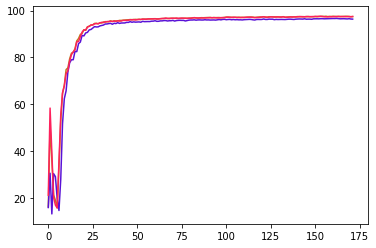

ROUND 171
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.407968
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.018083

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.100405
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.029578

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.435377
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.023716

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.259487
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.161622

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model c

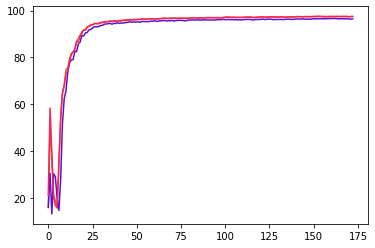

ROUND 172
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.280383
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.109087

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.121208
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.027274

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.114700
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.095492

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.195996
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.179988

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model c

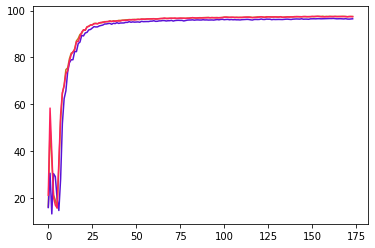

ROUND 173
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.172332
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.323088

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.095344
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.116741

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.281314
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.144058

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.138381
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.070499

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model c

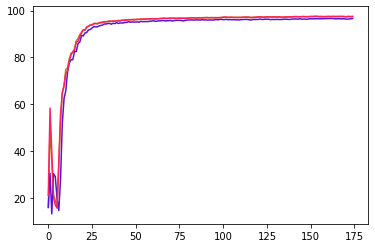

ROUND 174
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.297083
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.040996

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.348477
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.022557

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.310823
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.100717

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.321777
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.124189

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model c

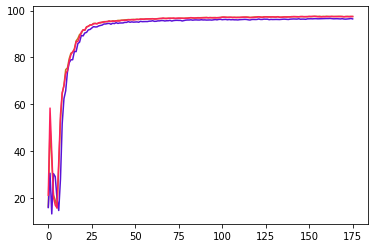

ROUND 175
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.322878
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.095258

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.269131
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.162351

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.281332
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.155849

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.407341
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.151014

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model c

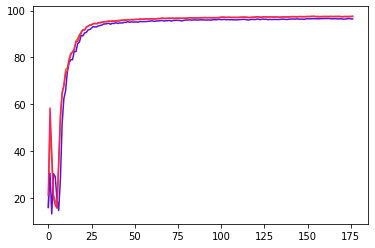

ROUND 176
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.160053
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.036174

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.206432
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.104310

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.307648
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.027906

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.276670
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.062157

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model c

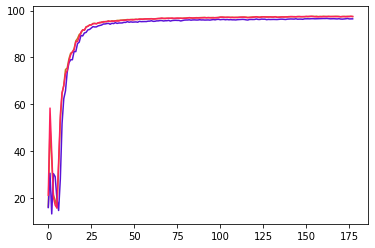

ROUND 177
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.190850
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.286336

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.292020
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.158648

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.313251
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.179331

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.320812
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.068183

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model c

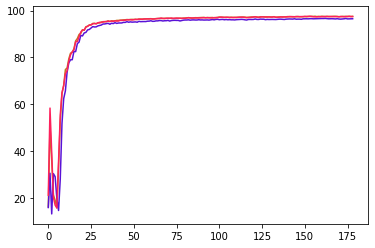

ROUND 178
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.378819
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.045112

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.331555
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.120673

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.405828
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.129483

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.298601
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.116899

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model c

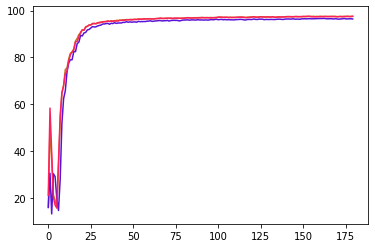

ROUND 179
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.273815
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.033316

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.303734
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.137329

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.244938
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.040337

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.162633
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.046925

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model c

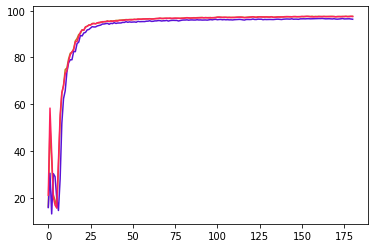

ROUND 180
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.261674
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.092005

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.233747
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.115053

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.208733
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.023721

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.235184
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.078160

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model c

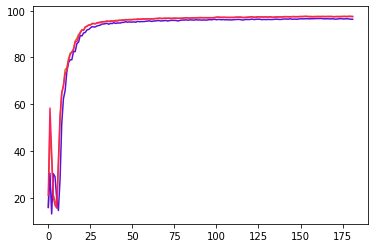

ROUND 181
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.138668
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.078117

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.202913
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.094391

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.122569
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.136542

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.267972
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.268981

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model c

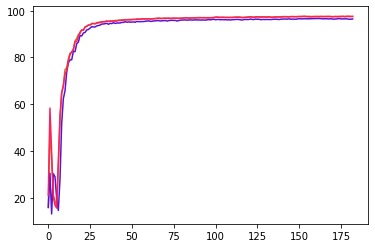

ROUND 182
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.173358
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.048600

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.323266
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.155665

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.128402
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.052743

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.132971
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.027258

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model c

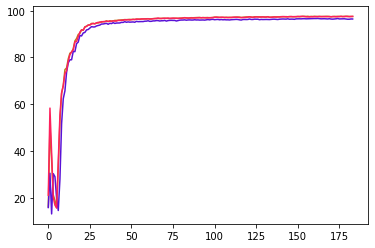

ROUND 183
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.223093
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.044039

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.268575
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.071177

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.358141
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.021435

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.219427
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.008634

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model c

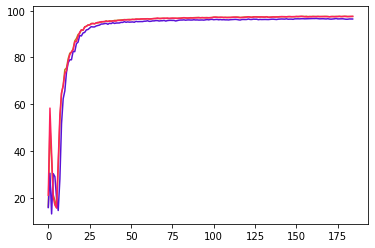

ROUND 184
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.077377
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.121493

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.228162
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.057405

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.104500
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.026328

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.402147
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.094025

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model c

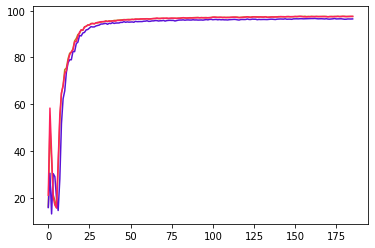

ROUND 185
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.141654
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.024156

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.088384
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.256124

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.126453
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.015677

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.206559
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.037059

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model c

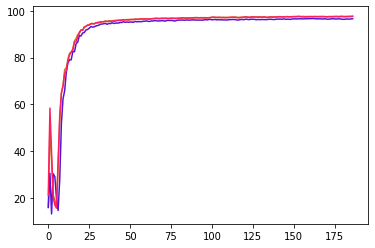

ROUND 186
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.203245
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.051010

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.109259
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.107752

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.212448
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.120963

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.329313
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.073717

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model c

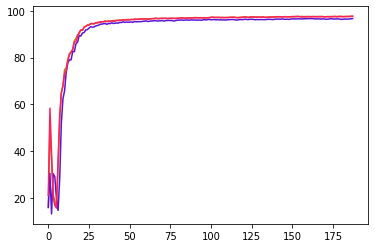

ROUND 187
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.198423
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.163001

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.109785
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.008854

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.149542
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.079868

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.290169
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.045321

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model c

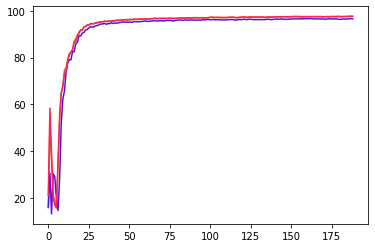

ROUND 188
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.175862
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.235928

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.077051
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.121206

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.327331
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.056715

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.153057
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.043608

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model c

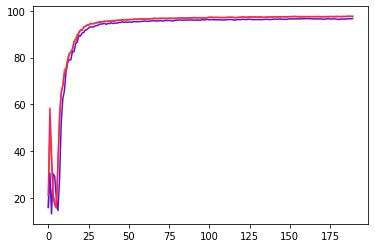

ROUND 189
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.230841
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.083508

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.203239
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.066082

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.340199
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.170359

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.269177
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.163985

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model c

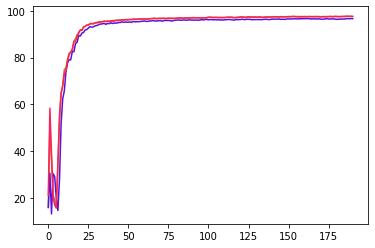

ROUND 190
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.389827
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.030645

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.282206
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.059533

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.325236
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.049796

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.308908
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.092008

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model c

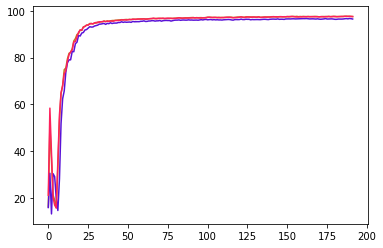

ROUND 191
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.190021
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.163783

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.269967
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.038120

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.236176
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.212517

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.180072
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.067325

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model c

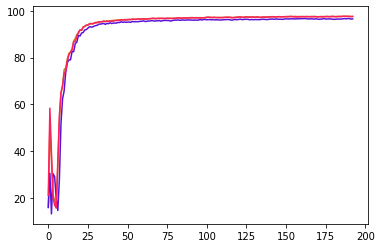

ROUND 192
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.098688
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.090013

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.303056
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.061319

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.280683
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.063030

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.198645
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.053873

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model c

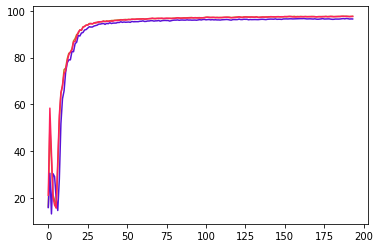

ROUND 193
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.214125
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.128575

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.254479
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.058316

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.291545
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.123913

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.145323
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.076650

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model c

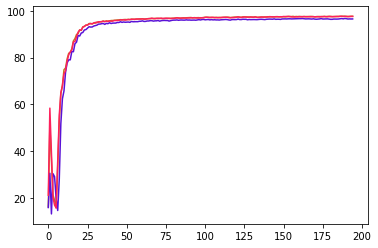

ROUND 194
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.203005
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.137868

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.417312
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.070132

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.277831
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.112594

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.258236
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.043752

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model c

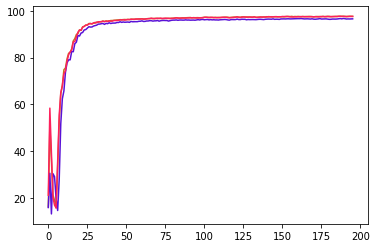

ROUND 195
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.199995
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.005206

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.095443
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.075827

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.218067
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.064603

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.212583
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.101651

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model c

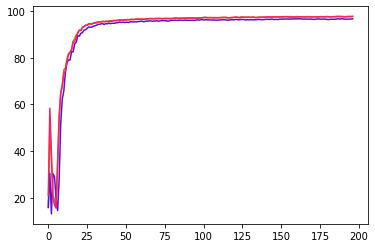

ROUND 196
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.199568
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.053416

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.137068
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.048632

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.173756
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.062379

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.448255
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.123118

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model c

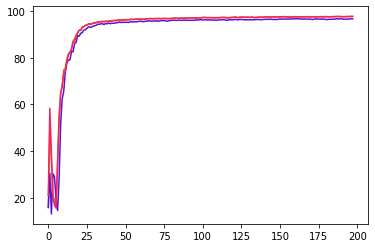

ROUND 197
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.124272
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.039013

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.137037
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.132633

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.096008
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.104366

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.124804
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.101384

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model c

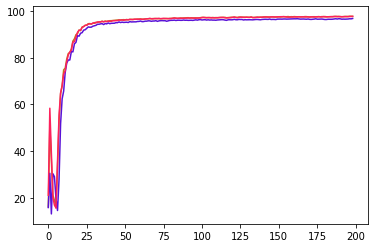

ROUND 198
0.16216000000000352
Power Allocated= 5.115045795001966
CSI= 0.9508386965582419
SNR= 31.53195231491787
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.285553
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.011156

Power Allocated= 3.7728322154589162
CSI= 0.41772548336417736
SNR= 27.31768455909234
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.104121
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.136422

Power Allocated= 2.7231548210431247
CSI= 0.29039427411583796
SNR= 36.65493121613333
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.268630
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.157635

Power Allocated= 5.100990957784415
CSI= 0.938299373418812
SNR= 42.047907555636506
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.179050
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.066098

Power Allocated= 3.997848937515101
CSI= 0.4610632218702342
SNR= 24.524444533800512
Client: client8
Model c

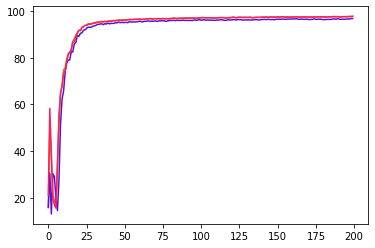

ROUND 199


In [14]:
for client in clients: #give the model and optimizer to every client
    torch.manual_seed(args.torch_seed)
    client['model'] = Net().to(device)
    #client['model'] = torch.quantization.quantize_dynamic(
    #client['model'],  # the original model
    #{torch.nn.Linear},  # a set of layers to dynamically quantize
    #dtype=torch.fp)  # the target dtype for quantized weights
    client['optim'] = optim.SGD(client['model'].parameters(), lr=args.lr)

final_acc=[]
final_loss=[]
clor = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]) for i in range(args.numclusters)]   
for fed_round in range(args.rounds):
    overall=Net()
    if(fed_round==0): #fed_round==0
        arranged_clusters,head_snr_list=cluster_former(args.numclusters,args.clients)
        temp=deepcopy(arranged_clusters)
        temp2=deepcopy(head_snr_list)
    else:
        #print(temp)
        arranged_clusters=deepcopy(temp)
        head_snr_list=deepcopy(temp2)
#     print(arranged_clusters)
    
    no=1
    heads_list=[]
    weights=[]
    weight_head_list=[]
    head_acc=[]
    head_loss=[]
    for cluster in arranged_clusters:
        
        head=cluster['Cluster Head']
        members=cluster['Members']
        snrs=cluster['SNR']
        csis=cluster['CSI']
        weights.append(sum(snrs))
        weight_head_list.append([head,sum(snrs)])
        new_members=[]
        
        for ij in members:
        #print(ij)
            cl_no=int(ij[6:])
            new_members.append(clients[cl_no-1])
#         print(head)
        head=clients[int(head[6:])-1]
        cluster['Members']=new_members
#         print(head)

        smallmu1=0
        gsmall1=3.402823466E+38 
        
        #water filling algorithm
        mu=1e-15
        while(mu<=1):
            g1=0
            pn1=0
            for jj in csis:
                pn=max(1/mu-1/jj,0)
                g1+=math.log(1+pn*jj) #capacity of a channel (shannon's law)
                pn1+=pn
            g=g1-mu*(pn1-P*30)
            if(g<gsmall1):
                smallmu1=mu
                gsmall1=g
            mu+=0.00002
        
        print(smallmu1)
        good_mem=[]
#         print(len(snrs))
#         print(len(csis))
#         print(len(new_members))
        index=0
        for client in new_members:
            goodchannel=ClientUpdate(args, device, client,key_np,key,snrs[index],csis[index],smallmu1,head)
            index+=1
            if(goodchannel):
                good_mem.append(client)
        
        head['model']=averageModels(head['model'], good_mem)
        arr=test(args,head['model'], device, global_test_loader, 'Cluster'+str(no),fed_round)
        ac=arr[0]#test(args,head['model'], device, global_test_loader, 'Cluster'+str(no),fed_round)[0]
        no+=1
        heads_list.append(head)
        head_acc.append(ac)
        head_loss.append(arr[1])#test(args,head['model'], device, global_test_loader, 'Cluster'+str(no),fed_round)[1])
    
    final_acc.append(head_acc)
    final_loss.append(head_loss)
    fig,ax=plt.subplots()
    
    #ax.plot([i for i in range(fed_round)],head_acc[0])
    for jj in range(0,args.numclusters):
        
        ax.plot([i for i in range(len(final_acc))],[final_acc[j][jj] for j in range(len(final_acc))], color = clor[jj])
        
    #ax.plot([i for i in range(len(final_acc))],[final_acc[j][0] for j in range(len(final_acc))], color ="red")
    #ax.plot([i for i in range(len(final_acc))],[final_acc[j][1] for j in range(len(final_acc))],color ="blue")
    #ax.plot([i for i in range(len(final_acc))],[final_acc[j][2] for j in range(len(final_acc))],color ="green")
    #ax.plot([i for i in range(len(final_acc))],[final_acc[j][3] for j in range(len(final_acc))],color ="black")
    #ax.plot([i for i in range(len(final_acc))],head_acc[1], fed_round, color ="blue")
    #ax.plot([i for i in range(len(final_acc))],head_acc[2], fed_round, color ="green")
    #ax.plot([i for i in range(len(final_acc))],head_acc[3], fed_round, color ="black")
    
    
    plt.show()
    weightsum=sum(weights)
    
    weights[:] = [x / weightsum for x in weights]
    for aah in range(len(weight_head_list)):
        weight_head_list[aah][1]=weights[aah]
    final_heads,nets=decentralized(heads_list,head_snr_list,weight_head_list)
    
    for head in range(len(final_heads)):
        for cluster in arranged_clusters:
            head1=cluster['Cluster Head']
            if(head1==final_heads[head]['hook'].id):
                for mem in cluster['Members']:
                    mem['model'].load_state_dict(nets[head].state_dict())
    print("ROUND",fed_round)

In [15]:
print(final_acc)

[[16.15, 15.87, 21.14], [50.85, 30.51, 58.36], [36.29, 13.13, 39.63], [21.19, 30.32, 20.14], [18.96, 29.06, 16.88], [15.7, 19.74, 15.69], [33.31, 14.59, 35.46], [52.88, 28.01, 55.49], [64.59, 51.74, 64.94], [68.14, 62.37, 67.85], [74.81, 65.73, 73.06], [75.53, 73.7, 74.35], [79.41, 77.7, 78.4], [81.82, 79.01, 81.14], [82.19, 79.02, 82.42], [83.76, 82.58, 83.22], [87.09, 82.48, 86.67], [88.11, 85.92, 86.83], [89.84, 86.57, 88.84], [90.27, 89.43, 90.85], [91.84, 89.2, 91.76], [91.59, 90.47, 91.72], [93.11, 90.71, 92.97], [93.36, 91.78, 93.29], [93.85, 91.96, 93.86], [93.94, 92.6, 93.88], [94.54, 93.18, 94.37], [94.6, 93.03, 94.46], [94.41, 93.07, 94.4], [94.74, 93.48, 94.79], [94.74, 93.65, 95.01], [95.18, 93.85, 94.88], [95.11, 94.29, 95.3], [95.3, 94.31, 95.29], [95.29, 94.47, 95.38], [95.67, 94.58, 95.47], [95.33, 94.18, 95.42], [95.67, 94.61, 95.54], [95.59, 94.47, 95.4], [95.63, 94.88, 95.7], [95.83, 94.55, 95.53], [95.84, 94.72, 95.56], [95.92, 94.73, 95.84], [96.04, 94.75, 95.82],